# Defining the Fully Convolutional Neural Network

In [107]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from PIL import Image
from matplotlib import cm
from torchsummary import summary

In [2]:
class FCNN(nn.Module):
    
    def __init__(self):
        super(FCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=5, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, stride=1)
        self.conv2_drop = nn.Dropout2d()
        
        self.conv3 = nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=2)
        self.conv3_drop = nn.Dropout2d()
        
        self.conv4 = nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, stride=1)
        
        self.conv5 = nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, stride=1)
        
        self.conv6 = nn.Conv2d(in_channels=120, out_channels=1, kernel_size=1, stride=1)
        
        
    def forward(self, data):
        x = F.relu(self.conv1(data))
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = F.relu(self.conv3_drop(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv6(x))
        return x
        
network = FCNN()

In [213]:
summary(network, (1,4000,3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 30, 1998, 1498]             780
            Conv2d-2       [-1, 60, 1996, 1496]          16,260
         Dropout2d-3       [-1, 60, 1996, 1496]               0
            Conv2d-4         [-1, 60, 997, 747]          32,460
         Dropout2d-5         [-1, 60, 997, 747]               0
            Conv2d-6        [-1, 120, 995, 745]          64,920
            Conv2d-7        [-1, 120, 993, 743]         129,720
            Conv2d-8          [-1, 1, 993, 743]             121
Total params: 244,261
Trainable params: 244,261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 45.78
Forward/backward pass size (MB): 5460.43
Params size (MB): 0.93
Estimated Total Size (MB): 5507.14
----------------------------------------------------------------


# Loading the samples

In [5]:
POLLEN_DATA_CREATED = False
cur_dir = os.getcwd()
pollen_files = cur_dir + '/Datasets/PollenData/'
np_pollen_data = []     # single date will be [img,label]


if not POLLEN_DATA_CREATED:
    for folder in next(os.walk(pollen_files))[1]:
        if folder == 'p':
            label = 1
        else:
            label = 0
        parent_path = os.path.join(pollen_files, folder)
        for file in os.listdir(parent_path):
            if '.png' in file:
                try:
                    path = os.path.join(parent_path, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    np_pollen_data.append([np.array(img), label])
                except Exception as e:
                    print(folder, file, str(e))

    np.random.shuffle(np_pollen_data)
    print("Data created.")


Data created.


In [9]:
# seperate the images and the labels into two lists:

images = []
labels = []

for i in range(len(np_pollen_data)):
    images.append(np_pollen_data[i][0]) #(Achtung: Zu Testzwecken wurden hier die Bilder auf 32x32 gecroppt.)
    labels.append(np_pollen_data[i][1])

print(len(images))

725760


In [10]:
# Split into train and validation set:

train_x = images[:int(len(images)*0.8)]
train_y = labels[:int(len(images)*0.8)]
valid_x = images[int(len(images)*0.8):]
valid_y = labels[int(len(images)*0.8):]

In [11]:
print(images[1].shape)

(32, 32)


In [12]:
# Create Dataloaders:

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(train_x),torch.Tensor(train_y)),batch_size=10)
validloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(valid_x),torch.Tensor(valid_y)),batch_size=100)

# Train the Network

First we have a look at the performance of the untrained model on our validation set. 

In [13]:
ep = 10;

#Which optimizer and criterion should we choose? Perform best?
criterion = nn.MSELoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)


In [126]:
def validate(network, testloader):
    total = 0
    correct = 0
    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    with torch.no_grad():
        validation_loss = 0
        for i, (inputs, labels) in enumerate(testloader):
            
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            #print(labels.size(0))
            loss = criterion(outputs,labels)
            validation_loss += loss.item()
            predicted = (outputs >= 0.95) # Predicted is a tensor of booleans 
            total += labels.size(0)
            predicted = predicted.view(predicted.size(0)) 
            #print(labels.size())
            #print((predicted == labels).sum().item())
            labels = labels == 1
            correct += (predicted == labels).sum().item()
            true_positive += (predicted & labels).sum().item()
            false_negative += (torch.logical_not(predicted) & labels).sum().item()
            false_positive += (predicted & torch.logical_not(labels)).sum().item()
            true_negative += (torch.logical_not(predicted) & torch.logical_not(labels)).sum().item()
            
        validation_loss = validation_loss / total 
        
        try: 
            recall = true_positive / (true_positive + false_negative)
        except ZeroDivisionError:
            recall = 0
        try:
            precision = true_positive / (true_positive + false_positive)
        except ZeroDivisionError:
            precision = 0
        try:
            F1_score = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            F1_score = 0
            
    # Kurzer Test, ob das stimmen kann:
    # print(true_positive)
    # print(false_negative)
    # print(false_positive)
    # print(true_negative)
    # print(total)
    
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
    print('F1 Score of the network on the test images: %f' % F1_score)
    return validation_loss, F1_score, (correct / total)
    
validate(network, validloader)

Accuracy of the network on the test images: 89 %
F1 Score of the network on the test images: 0.889582


(0.0005085095719159348, 0.8895818546986605, 0.8992504409171076)

In [15]:
# from pytorch blitz tutorial

def train(network, trainloader, ep, criterion, optimizer, print_interval):
    losses = [] # Mean of loss/image in every epoch of training 
    validation_losses = []
    F1 = []
    accuracy = []
    validate(network, validloader)
    
    for epoch in range(ep):

        loss_stats = 0.0
        total = 0
        
        running_loss = 0.0
    
        for i, (inputs, lables) in enumerate(trainloader):
    
            # zero the parameter gradients
            optimizer.zero_grad()
            #print(lables.shape)
            
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            #print(outputs.shape)
            loss = criterion(outputs, lables)
            loss.backward() #propagate the error back through the network
            optimizer.step() #adjust the weights of the network depending on the propagated error
    
            #that's it.
            total += lables.shape[0]
            
            #Some statistics:
            running_loss += loss.item()
            
            loss_stats += loss.item()
            
            if i % print_interval == print_interval - 1:    # print every x mini-batches (loss for one batch)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_interval))
                running_loss = 0.0
        
        losses.append(loss_stats / total)
        #Test the network using the validation set after every epoch of training.
        val_loss_curr, F1_curr, accuracy_curr = validate(network, validloader)
        validation_losses.append(val_loss_curr)
        F1.append(F1_curr)
        accuracy.append(accuracy_curr)
        
    print('Finished Training')
    return losses, validation_losses, F1, accuracy

train_losses, val_losses, F1_scores, accuracies = train(network, trainloader, ep, criterion, optimizer, 32)

Accuracy of the network on the test images: 49 %
F1 Score of the network on the test images: 0.015208
[1,    32] loss: 0.248
[1,    64] loss: 0.228
[1,    96] loss: 0.182
[1,   128] loss: 0.188
[1,   160] loss: 0.150
[1,   192] loss: 0.122
[1,   224] loss: 0.143
[1,   256] loss: 0.144
[1,   288] loss: 0.108
[1,   320] loss: 0.109
[1,   352] loss: 0.114
[1,   384] loss: 0.097
[1,   416] loss: 0.099
[1,   448] loss: 0.089
[1,   480] loss: 0.111
[1,   512] loss: 0.105
[1,   544] loss: 0.104
[1,   576] loss: 0.086
[1,   608] loss: 0.115
[1,   640] loss: 0.093
[1,   672] loss: 0.111
[1,   704] loss: 0.100
[1,   736] loss: 0.118
[1,   768] loss: 0.117
[1,   800] loss: 0.095
[1,   832] loss: 0.115
[1,   864] loss: 0.070
[1,   896] loss: 0.090
[1,   928] loss: 0.116
[1,   960] loss: 0.088
[1,   992] loss: 0.084
[1,  1024] loss: 0.128
[1,  1056] loss: 0.132
[1,  1088] loss: 0.110
[1,  1120] loss: 0.069
[1,  1152] loss: 0.099
[1,  1184] loss: 0.100
[1,  1216] loss: 0.106
[1,  1248] loss: 0.085
[

[1, 11296] loss: 0.078
[1, 11328] loss: 0.070
[1, 11360] loss: 0.080
[1, 11392] loss: 0.063
[1, 11424] loss: 0.074
[1, 11456] loss: 0.063
[1, 11488] loss: 0.104
[1, 11520] loss: 0.080
[1, 11552] loss: 0.080
[1, 11584] loss: 0.076
[1, 11616] loss: 0.080
[1, 11648] loss: 0.090
[1, 11680] loss: 0.071
[1, 11712] loss: 0.082
[1, 11744] loss: 0.065
[1, 11776] loss: 0.099
[1, 11808] loss: 0.079
[1, 11840] loss: 0.083
[1, 11872] loss: 0.066
[1, 11904] loss: 0.065
[1, 11936] loss: 0.064
[1, 11968] loss: 0.045
[1, 12000] loss: 0.089
[1, 12032] loss: 0.057
[1, 12064] loss: 0.087
[1, 12096] loss: 0.076
[1, 12128] loss: 0.053
[1, 12160] loss: 0.066
[1, 12192] loss: 0.082
[1, 12224] loss: 0.077
[1, 12256] loss: 0.059
[1, 12288] loss: 0.091
[1, 12320] loss: 0.058
[1, 12352] loss: 0.099
[1, 12384] loss: 0.073
[1, 12416] loss: 0.071
[1, 12448] loss: 0.061
[1, 12480] loss: 0.072
[1, 12512] loss: 0.065
[1, 12544] loss: 0.071
[1, 12576] loss: 0.055
[1, 12608] loss: 0.076
[1, 12640] loss: 0.076
[1, 12672] 

[1, 22720] loss: 0.067
[1, 22752] loss: 0.065
[1, 22784] loss: 0.063
[1, 22816] loss: 0.090
[1, 22848] loss: 0.085
[1, 22880] loss: 0.063
[1, 22912] loss: 0.059
[1, 22944] loss: 0.072
[1, 22976] loss: 0.067
[1, 23008] loss: 0.075
[1, 23040] loss: 0.068
[1, 23072] loss: 0.090
[1, 23104] loss: 0.066
[1, 23136] loss: 0.054
[1, 23168] loss: 0.063
[1, 23200] loss: 0.063
[1, 23232] loss: 0.056
[1, 23264] loss: 0.065
[1, 23296] loss: 0.061
[1, 23328] loss: 0.050
[1, 23360] loss: 0.058
[1, 23392] loss: 0.060
[1, 23424] loss: 0.062
[1, 23456] loss: 0.068
[1, 23488] loss: 0.063
[1, 23520] loss: 0.069
[1, 23552] loss: 0.065
[1, 23584] loss: 0.085
[1, 23616] loss: 0.062
[1, 23648] loss: 0.089
[1, 23680] loss: 0.058
[1, 23712] loss: 0.060
[1, 23744] loss: 0.098
[1, 23776] loss: 0.074
[1, 23808] loss: 0.080
[1, 23840] loss: 0.082
[1, 23872] loss: 0.078
[1, 23904] loss: 0.061
[1, 23936] loss: 0.051
[1, 23968] loss: 0.054
[1, 24000] loss: 0.045
[1, 24032] loss: 0.076
[1, 24064] loss: 0.077
[1, 24096] 

[1, 34144] loss: 0.071
[1, 34176] loss: 0.068
[1, 34208] loss: 0.064
[1, 34240] loss: 0.058
[1, 34272] loss: 0.075
[1, 34304] loss: 0.068
[1, 34336] loss: 0.066
[1, 34368] loss: 0.074
[1, 34400] loss: 0.078
[1, 34432] loss: 0.071
[1, 34464] loss: 0.072
[1, 34496] loss: 0.070
[1, 34528] loss: 0.083
[1, 34560] loss: 0.086
[1, 34592] loss: 0.065
[1, 34624] loss: 0.065
[1, 34656] loss: 0.078
[1, 34688] loss: 0.081
[1, 34720] loss: 0.053
[1, 34752] loss: 0.071
[1, 34784] loss: 0.089
[1, 34816] loss: 0.084
[1, 34848] loss: 0.089
[1, 34880] loss: 0.068
[1, 34912] loss: 0.067
[1, 34944] loss: 0.064
[1, 34976] loss: 0.058
[1, 35008] loss: 0.063
[1, 35040] loss: 0.076
[1, 35072] loss: 0.072
[1, 35104] loss: 0.064
[1, 35136] loss: 0.065
[1, 35168] loss: 0.062
[1, 35200] loss: 0.062
[1, 35232] loss: 0.074
[1, 35264] loss: 0.061
[1, 35296] loss: 0.071
[1, 35328] loss: 0.053
[1, 35360] loss: 0.056
[1, 35392] loss: 0.081
[1, 35424] loss: 0.062
[1, 35456] loss: 0.075
[1, 35488] loss: 0.067
[1, 35520] 

[1, 45568] loss: 0.067
[1, 45600] loss: 0.066
[1, 45632] loss: 0.073
[1, 45664] loss: 0.049
[1, 45696] loss: 0.065
[1, 45728] loss: 0.072
[1, 45760] loss: 0.072
[1, 45792] loss: 0.067
[1, 45824] loss: 0.066
[1, 45856] loss: 0.069
[1, 45888] loss: 0.072
[1, 45920] loss: 0.061
[1, 45952] loss: 0.086
[1, 45984] loss: 0.060
[1, 46016] loss: 0.074
[1, 46048] loss: 0.052
[1, 46080] loss: 0.071
[1, 46112] loss: 0.056
[1, 46144] loss: 0.065
[1, 46176] loss: 0.041
[1, 46208] loss: 0.060
[1, 46240] loss: 0.059
[1, 46272] loss: 0.068
[1, 46304] loss: 0.061
[1, 46336] loss: 0.060
[1, 46368] loss: 0.061
[1, 46400] loss: 0.047
[1, 46432] loss: 0.069
[1, 46464] loss: 0.052
[1, 46496] loss: 0.079
[1, 46528] loss: 0.073
[1, 46560] loss: 0.067
[1, 46592] loss: 0.079
[1, 46624] loss: 0.065
[1, 46656] loss: 0.064
[1, 46688] loss: 0.068
[1, 46720] loss: 0.070
[1, 46752] loss: 0.080
[1, 46784] loss: 0.066
[1, 46816] loss: 0.054
[1, 46848] loss: 0.052
[1, 46880] loss: 0.063
[1, 46912] loss: 0.076
[1, 46944] 

[1, 56992] loss: 0.054
[1, 57024] loss: 0.062
[1, 57056] loss: 0.101
[1, 57088] loss: 0.068
[1, 57120] loss: 0.085
[1, 57152] loss: 0.077
[1, 57184] loss: 0.059
[1, 57216] loss: 0.056
[1, 57248] loss: 0.049
[1, 57280] loss: 0.081
[1, 57312] loss: 0.065
[1, 57344] loss: 0.052
[1, 57376] loss: 0.053
[1, 57408] loss: 0.059
[1, 57440] loss: 0.070
[1, 57472] loss: 0.066
[1, 57504] loss: 0.056
[1, 57536] loss: 0.059
[1, 57568] loss: 0.066
[1, 57600] loss: 0.070
[1, 57632] loss: 0.070
[1, 57664] loss: 0.062
[1, 57696] loss: 0.066
[1, 57728] loss: 0.054
[1, 57760] loss: 0.072
[1, 57792] loss: 0.067
[1, 57824] loss: 0.074
[1, 57856] loss: 0.056
[1, 57888] loss: 0.080
[1, 57920] loss: 0.052
[1, 57952] loss: 0.070
[1, 57984] loss: 0.055
[1, 58016] loss: 0.073
[1, 58048] loss: 0.065
Accuracy of the network on the test images: 83 %
F1 Score of the network on the test images: 0.802926
[2,    32] loss: 0.054
[2,    64] loss: 0.061
[2,    96] loss: 0.064
[2,   128] loss: 0.089
[2,   160] loss: 0.066
[

[2, 10208] loss: 0.068
[2, 10240] loss: 0.061
[2, 10272] loss: 0.083
[2, 10304] loss: 0.069
[2, 10336] loss: 0.086
[2, 10368] loss: 0.069
[2, 10400] loss: 0.058
[2, 10432] loss: 0.053
[2, 10464] loss: 0.053
[2, 10496] loss: 0.051
[2, 10528] loss: 0.064
[2, 10560] loss: 0.074
[2, 10592] loss: 0.063
[2, 10624] loss: 0.074
[2, 10656] loss: 0.063
[2, 10688] loss: 0.066
[2, 10720] loss: 0.064
[2, 10752] loss: 0.050
[2, 10784] loss: 0.068
[2, 10816] loss: 0.080
[2, 10848] loss: 0.057
[2, 10880] loss: 0.054
[2, 10912] loss: 0.060
[2, 10944] loss: 0.056
[2, 10976] loss: 0.064
[2, 11008] loss: 0.069
[2, 11040] loss: 0.054
[2, 11072] loss: 0.070
[2, 11104] loss: 0.071
[2, 11136] loss: 0.072
[2, 11168] loss: 0.053
[2, 11200] loss: 0.073
[2, 11232] loss: 0.065
[2, 11264] loss: 0.068
[2, 11296] loss: 0.071
[2, 11328] loss: 0.057
[2, 11360] loss: 0.056
[2, 11392] loss: 0.068
[2, 11424] loss: 0.071
[2, 11456] loss: 0.059
[2, 11488] loss: 0.085
[2, 11520] loss: 0.073
[2, 11552] loss: 0.065
[2, 11584] 

[2, 21632] loss: 0.075
[2, 21664] loss: 0.069
[2, 21696] loss: 0.068
[2, 21728] loss: 0.063
[2, 21760] loss: 0.099
[2, 21792] loss: 0.074
[2, 21824] loss: 0.072
[2, 21856] loss: 0.072
[2, 21888] loss: 0.070
[2, 21920] loss: 0.049
[2, 21952] loss: 0.070
[2, 21984] loss: 0.087
[2, 22016] loss: 0.060
[2, 22048] loss: 0.060
[2, 22080] loss: 0.069
[2, 22112] loss: 0.073
[2, 22144] loss: 0.071
[2, 22176] loss: 0.068
[2, 22208] loss: 0.069
[2, 22240] loss: 0.051
[2, 22272] loss: 0.069
[2, 22304] loss: 0.074
[2, 22336] loss: 0.063
[2, 22368] loss: 0.065
[2, 22400] loss: 0.076
[2, 22432] loss: 0.049
[2, 22464] loss: 0.055
[2, 22496] loss: 0.044
[2, 22528] loss: 0.079
[2, 22560] loss: 0.055
[2, 22592] loss: 0.062
[2, 22624] loss: 0.062
[2, 22656] loss: 0.076
[2, 22688] loss: 0.064
[2, 22720] loss: 0.068
[2, 22752] loss: 0.062
[2, 22784] loss: 0.059
[2, 22816] loss: 0.079
[2, 22848] loss: 0.076
[2, 22880] loss: 0.052
[2, 22912] loss: 0.060
[2, 22944] loss: 0.068
[2, 22976] loss: 0.067
[2, 23008] 

[2, 33056] loss: 0.074
[2, 33088] loss: 0.064
[2, 33120] loss: 0.065
[2, 33152] loss: 0.075
[2, 33184] loss: 0.064
[2, 33216] loss: 0.059
[2, 33248] loss: 0.057
[2, 33280] loss: 0.075
[2, 33312] loss: 0.071
[2, 33344] loss: 0.065
[2, 33376] loss: 0.066
[2, 33408] loss: 0.066
[2, 33440] loss: 0.068
[2, 33472] loss: 0.061
[2, 33504] loss: 0.066
[2, 33536] loss: 0.066
[2, 33568] loss: 0.082
[2, 33600] loss: 0.068
[2, 33632] loss: 0.063
[2, 33664] loss: 0.046
[2, 33696] loss: 0.059
[2, 33728] loss: 0.072
[2, 33760] loss: 0.050
[2, 33792] loss: 0.090
[2, 33824] loss: 0.079
[2, 33856] loss: 0.060
[2, 33888] loss: 0.062
[2, 33920] loss: 0.058
[2, 33952] loss: 0.062
[2, 33984] loss: 0.041
[2, 34016] loss: 0.059
[2, 34048] loss: 0.058
[2, 34080] loss: 0.076
[2, 34112] loss: 0.082
[2, 34144] loss: 0.075
[2, 34176] loss: 0.062
[2, 34208] loss: 0.065
[2, 34240] loss: 0.061
[2, 34272] loss: 0.067
[2, 34304] loss: 0.066
[2, 34336] loss: 0.058
[2, 34368] loss: 0.074
[2, 34400] loss: 0.075
[2, 34432] 

[2, 44480] loss: 0.068
[2, 44512] loss: 0.061
[2, 44544] loss: 0.062
[2, 44576] loss: 0.066
[2, 44608] loss: 0.059
[2, 44640] loss: 0.066
[2, 44672] loss: 0.049
[2, 44704] loss: 0.068
[2, 44736] loss: 0.057
[2, 44768] loss: 0.057
[2, 44800] loss: 0.080
[2, 44832] loss: 0.064
[2, 44864] loss: 0.053
[2, 44896] loss: 0.052
[2, 44928] loss: 0.060
[2, 44960] loss: 0.070
[2, 44992] loss: 0.061
[2, 45024] loss: 0.052
[2, 45056] loss: 0.092
[2, 45088] loss: 0.082
[2, 45120] loss: 0.062
[2, 45152] loss: 0.067
[2, 45184] loss: 0.066
[2, 45216] loss: 0.080
[2, 45248] loss: 0.070
[2, 45280] loss: 0.060
[2, 45312] loss: 0.054
[2, 45344] loss: 0.087
[2, 45376] loss: 0.075
[2, 45408] loss: 0.062
[2, 45440] loss: 0.079
[2, 45472] loss: 0.070
[2, 45504] loss: 0.059
[2, 45536] loss: 0.082
[2, 45568] loss: 0.060
[2, 45600] loss: 0.069
[2, 45632] loss: 0.078
[2, 45664] loss: 0.048
[2, 45696] loss: 0.072
[2, 45728] loss: 0.071
[2, 45760] loss: 0.059
[2, 45792] loss: 0.061
[2, 45824] loss: 0.061
[2, 45856] 

[2, 55904] loss: 0.070
[2, 55936] loss: 0.053
[2, 55968] loss: 0.077
[2, 56000] loss: 0.073
[2, 56032] loss: 0.037
[2, 56064] loss: 0.058
[2, 56096] loss: 0.063
[2, 56128] loss: 0.052
[2, 56160] loss: 0.061
[2, 56192] loss: 0.076
[2, 56224] loss: 0.063
[2, 56256] loss: 0.076
[2, 56288] loss: 0.058
[2, 56320] loss: 0.063
[2, 56352] loss: 0.057
[2, 56384] loss: 0.076
[2, 56416] loss: 0.052
[2, 56448] loss: 0.059
[2, 56480] loss: 0.068
[2, 56512] loss: 0.063
[2, 56544] loss: 0.054
[2, 56576] loss: 0.044
[2, 56608] loss: 0.060
[2, 56640] loss: 0.065
[2, 56672] loss: 0.060
[2, 56704] loss: 0.072
[2, 56736] loss: 0.062
[2, 56768] loss: 0.048
[2, 56800] loss: 0.060
[2, 56832] loss: 0.057
[2, 56864] loss: 0.042
[2, 56896] loss: 0.063
[2, 56928] loss: 0.079
[2, 56960] loss: 0.061
[2, 56992] loss: 0.054
[2, 57024] loss: 0.053
[2, 57056] loss: 0.085
[2, 57088] loss: 0.065
[2, 57120] loss: 0.087
[2, 57152] loss: 0.072
[2, 57184] loss: 0.059
[2, 57216] loss: 0.046
[2, 57248] loss: 0.048
[2, 57280] 

[3,  9120] loss: 0.050
[3,  9152] loss: 0.057
[3,  9184] loss: 0.063
[3,  9216] loss: 0.063
[3,  9248] loss: 0.055
[3,  9280] loss: 0.068
[3,  9312] loss: 0.069
[3,  9344] loss: 0.066
[3,  9376] loss: 0.054
[3,  9408] loss: 0.063
[3,  9440] loss: 0.056
[3,  9472] loss: 0.058
[3,  9504] loss: 0.060
[3,  9536] loss: 0.061
[3,  9568] loss: 0.052
[3,  9600] loss: 0.056
[3,  9632] loss: 0.081
[3,  9664] loss: 0.066
[3,  9696] loss: 0.062
[3,  9728] loss: 0.061
[3,  9760] loss: 0.061
[3,  9792] loss: 0.058
[3,  9824] loss: 0.071
[3,  9856] loss: 0.055
[3,  9888] loss: 0.052
[3,  9920] loss: 0.065
[3,  9952] loss: 0.052
[3,  9984] loss: 0.074
[3, 10016] loss: 0.059
[3, 10048] loss: 0.066
[3, 10080] loss: 0.052
[3, 10112] loss: 0.076
[3, 10144] loss: 0.061
[3, 10176] loss: 0.056
[3, 10208] loss: 0.066
[3, 10240] loss: 0.046
[3, 10272] loss: 0.084
[3, 10304] loss: 0.065
[3, 10336] loss: 0.085
[3, 10368] loss: 0.066
[3, 10400] loss: 0.060
[3, 10432] loss: 0.055
[3, 10464] loss: 0.045
[3, 10496] 

[3, 20544] loss: 0.074
[3, 20576] loss: 0.049
[3, 20608] loss: 0.062
[3, 20640] loss: 0.035
[3, 20672] loss: 0.076
[3, 20704] loss: 0.062
[3, 20736] loss: 0.074
[3, 20768] loss: 0.061
[3, 20800] loss: 0.079
[3, 20832] loss: 0.071
[3, 20864] loss: 0.067
[3, 20896] loss: 0.073
[3, 20928] loss: 0.101
[3, 20960] loss: 0.068
[3, 20992] loss: 0.054
[3, 21024] loss: 0.068
[3, 21056] loss: 0.067
[3, 21088] loss: 0.054
[3, 21120] loss: 0.065
[3, 21152] loss: 0.051
[3, 21184] loss: 0.055
[3, 21216] loss: 0.061
[3, 21248] loss: 0.050
[3, 21280] loss: 0.044
[3, 21312] loss: 0.063
[3, 21344] loss: 0.048
[3, 21376] loss: 0.067
[3, 21408] loss: 0.102
[3, 21440] loss: 0.068
[3, 21472] loss: 0.077
[3, 21504] loss: 0.052
[3, 21536] loss: 0.060
[3, 21568] loss: 0.063
[3, 21600] loss: 0.070
[3, 21632] loss: 0.072
[3, 21664] loss: 0.070
[3, 21696] loss: 0.072
[3, 21728] loss: 0.057
[3, 21760] loss: 0.094
[3, 21792] loss: 0.075
[3, 21824] loss: 0.075
[3, 21856] loss: 0.059
[3, 21888] loss: 0.075
[3, 21920] 

[3, 31968] loss: 0.055
[3, 32000] loss: 0.076
[3, 32032] loss: 0.065
[3, 32064] loss: 0.049
[3, 32096] loss: 0.064
[3, 32128] loss: 0.067
[3, 32160] loss: 0.071
[3, 32192] loss: 0.052
[3, 32224] loss: 0.066
[3, 32256] loss: 0.064
[3, 32288] loss: 0.071
[3, 32320] loss: 0.049
[3, 32352] loss: 0.071
[3, 32384] loss: 0.056
[3, 32416] loss: 0.071
[3, 32448] loss: 0.060
[3, 32480] loss: 0.081
[3, 32512] loss: 0.059
[3, 32544] loss: 0.061
[3, 32576] loss: 0.061
[3, 32608] loss: 0.075
[3, 32640] loss: 0.050
[3, 32672] loss: 0.055
[3, 32704] loss: 0.056
[3, 32736] loss: 0.069
[3, 32768] loss: 0.059
[3, 32800] loss: 0.054
[3, 32832] loss: 0.054
[3, 32864] loss: 0.035
[3, 32896] loss: 0.066
[3, 32928] loss: 0.050
[3, 32960] loss: 0.063
[3, 32992] loss: 0.066
[3, 33024] loss: 0.063
[3, 33056] loss: 0.073
[3, 33088] loss: 0.071
[3, 33120] loss: 0.056
[3, 33152] loss: 0.067
[3, 33184] loss: 0.060
[3, 33216] loss: 0.059
[3, 33248] loss: 0.058
[3, 33280] loss: 0.068
[3, 33312] loss: 0.066
[3, 33344] 

[3, 43392] loss: 0.078
[3, 43424] loss: 0.081
[3, 43456] loss: 0.074
[3, 43488] loss: 0.058
[3, 43520] loss: 0.063
[3, 43552] loss: 0.075
[3, 43584] loss: 0.053
[3, 43616] loss: 0.078
[3, 43648] loss: 0.056
[3, 43680] loss: 0.078
[3, 43712] loss: 0.053
[3, 43744] loss: 0.055
[3, 43776] loss: 0.067
[3, 43808] loss: 0.061
[3, 43840] loss: 0.053
[3, 43872] loss: 0.067
[3, 43904] loss: 0.048
[3, 43936] loss: 0.065
[3, 43968] loss: 0.056
[3, 44000] loss: 0.054
[3, 44032] loss: 0.066
[3, 44064] loss: 0.090
[3, 44096] loss: 0.057
[3, 44128] loss: 0.072
[3, 44160] loss: 0.077
[3, 44192] loss: 0.068
[3, 44224] loss: 0.048
[3, 44256] loss: 0.076
[3, 44288] loss: 0.059
[3, 44320] loss: 0.041
[3, 44352] loss: 0.063
[3, 44384] loss: 0.069
[3, 44416] loss: 0.078
[3, 44448] loss: 0.050
[3, 44480] loss: 0.072
[3, 44512] loss: 0.059
[3, 44544] loss: 0.061
[3, 44576] loss: 0.063
[3, 44608] loss: 0.060
[3, 44640] loss: 0.063
[3, 44672] loss: 0.052
[3, 44704] loss: 0.056
[3, 44736] loss: 0.065
[3, 44768] 

[3, 54816] loss: 0.075
[3, 54848] loss: 0.070
[3, 54880] loss: 0.050
[3, 54912] loss: 0.050
[3, 54944] loss: 0.067
[3, 54976] loss: 0.078
[3, 55008] loss: 0.049
[3, 55040] loss: 0.069
[3, 55072] loss: 0.067
[3, 55104] loss: 0.077
[3, 55136] loss: 0.061
[3, 55168] loss: 0.084
[3, 55200] loss: 0.068
[3, 55232] loss: 0.056
[3, 55264] loss: 0.070
[3, 55296] loss: 0.077
[3, 55328] loss: 0.042
[3, 55360] loss: 0.064
[3, 55392] loss: 0.062
[3, 55424] loss: 0.062
[3, 55456] loss: 0.075
[3, 55488] loss: 0.054
[3, 55520] loss: 0.044
[3, 55552] loss: 0.056
[3, 55584] loss: 0.066
[3, 55616] loss: 0.047
[3, 55648] loss: 0.056
[3, 55680] loss: 0.051
[3, 55712] loss: 0.073
[3, 55744] loss: 0.057
[3, 55776] loss: 0.069
[3, 55808] loss: 0.068
[3, 55840] loss: 0.047
[3, 55872] loss: 0.057
[3, 55904] loss: 0.076
[3, 55936] loss: 0.053
[3, 55968] loss: 0.074
[3, 56000] loss: 0.064
[3, 56032] loss: 0.041
[3, 56064] loss: 0.054
[3, 56096] loss: 0.079
[3, 56128] loss: 0.051
[3, 56160] loss: 0.068
[3, 56192] 

[4,  8032] loss: 0.056
[4,  8064] loss: 0.072
[4,  8096] loss: 0.054
[4,  8128] loss: 0.051
[4,  8160] loss: 0.050
[4,  8192] loss: 0.049
[4,  8224] loss: 0.052
[4,  8256] loss: 0.050
[4,  8288] loss: 0.070
[4,  8320] loss: 0.062
[4,  8352] loss: 0.045
[4,  8384] loss: 0.052
[4,  8416] loss: 0.068
[4,  8448] loss: 0.058
[4,  8480] loss: 0.066
[4,  8512] loss: 0.069
[4,  8544] loss: 0.083
[4,  8576] loss: 0.060
[4,  8608] loss: 0.062
[4,  8640] loss: 0.064
[4,  8672] loss: 0.071
[4,  8704] loss: 0.070
[4,  8736] loss: 0.055
[4,  8768] loss: 0.067
[4,  8800] loss: 0.071
[4,  8832] loss: 0.050
[4,  8864] loss: 0.059
[4,  8896] loss: 0.069
[4,  8928] loss: 0.048
[4,  8960] loss: 0.050
[4,  8992] loss: 0.053
[4,  9024] loss: 0.052
[4,  9056] loss: 0.054
[4,  9088] loss: 0.066
[4,  9120] loss: 0.043
[4,  9152] loss: 0.065
[4,  9184] loss: 0.059
[4,  9216] loss: 0.064
[4,  9248] loss: 0.052
[4,  9280] loss: 0.063
[4,  9312] loss: 0.064
[4,  9344] loss: 0.063
[4,  9376] loss: 0.055
[4,  9408] 

[4, 19456] loss: 0.062
[4, 19488] loss: 0.071
[4, 19520] loss: 0.061
[4, 19552] loss: 0.057
[4, 19584] loss: 0.061
[4, 19616] loss: 0.060
[4, 19648] loss: 0.070
[4, 19680] loss: 0.054
[4, 19712] loss: 0.103
[4, 19744] loss: 0.075
[4, 19776] loss: 0.049
[4, 19808] loss: 0.053
[4, 19840] loss: 0.059
[4, 19872] loss: 0.078
[4, 19904] loss: 0.054
[4, 19936] loss: 0.077
[4, 19968] loss: 0.055
[4, 20000] loss: 0.065
[4, 20032] loss: 0.058
[4, 20064] loss: 0.063
[4, 20096] loss: 0.042
[4, 20128] loss: 0.057
[4, 20160] loss: 0.074
[4, 20192] loss: 0.059
[4, 20224] loss: 0.049
[4, 20256] loss: 0.052
[4, 20288] loss: 0.055
[4, 20320] loss: 0.058
[4, 20352] loss: 0.065
[4, 20384] loss: 0.056
[4, 20416] loss: 0.079
[4, 20448] loss: 0.058
[4, 20480] loss: 0.060
[4, 20512] loss: 0.061
[4, 20544] loss: 0.072
[4, 20576] loss: 0.044
[4, 20608] loss: 0.052
[4, 20640] loss: 0.030
[4, 20672] loss: 0.063
[4, 20704] loss: 0.056
[4, 20736] loss: 0.064
[4, 20768] loss: 0.054
[4, 20800] loss: 0.069
[4, 20832] 

[4, 30880] loss: 0.054
[4, 30912] loss: 0.069
[4, 30944] loss: 0.062
[4, 30976] loss: 0.053
[4, 31008] loss: 0.050
[4, 31040] loss: 0.081
[4, 31072] loss: 0.061
[4, 31104] loss: 0.059
[4, 31136] loss: 0.079
[4, 31168] loss: 0.070
[4, 31200] loss: 0.070
[4, 31232] loss: 0.051
[4, 31264] loss: 0.054
[4, 31296] loss: 0.081
[4, 31328] loss: 0.056
[4, 31360] loss: 0.061
[4, 31392] loss: 0.054
[4, 31424] loss: 0.049
[4, 31456] loss: 0.088
[4, 31488] loss: 0.048
[4, 31520] loss: 0.054
[4, 31552] loss: 0.079
[4, 31584] loss: 0.059
[4, 31616] loss: 0.069
[4, 31648] loss: 0.061
[4, 31680] loss: 0.042
[4, 31712] loss: 0.040
[4, 31744] loss: 0.070
[4, 31776] loss: 0.055
[4, 31808] loss: 0.069
[4, 31840] loss: 0.050
[4, 31872] loss: 0.052
[4, 31904] loss: 0.065
[4, 31936] loss: 0.065
[4, 31968] loss: 0.050
[4, 32000] loss: 0.084
[4, 32032] loss: 0.062
[4, 32064] loss: 0.045
[4, 32096] loss: 0.061
[4, 32128] loss: 0.068
[4, 32160] loss: 0.082
[4, 32192] loss: 0.055
[4, 32224] loss: 0.055
[4, 32256] 

[4, 42304] loss: 0.033
[4, 42336] loss: 0.076
[4, 42368] loss: 0.056
[4, 42400] loss: 0.056
[4, 42432] loss: 0.066
[4, 42464] loss: 0.061
[4, 42496] loss: 0.052
[4, 42528] loss: 0.069
[4, 42560] loss: 0.077
[4, 42592] loss: 0.053
[4, 42624] loss: 0.068
[4, 42656] loss: 0.070
[4, 42688] loss: 0.056
[4, 42720] loss: 0.060
[4, 42752] loss: 0.043
[4, 42784] loss: 0.066
[4, 42816] loss: 0.066
[4, 42848] loss: 0.058
[4, 42880] loss: 0.084
[4, 42912] loss: 0.061
[4, 42944] loss: 0.053
[4, 42976] loss: 0.059
[4, 43008] loss: 0.072
[4, 43040] loss: 0.070
[4, 43072] loss: 0.066
[4, 43104] loss: 0.071
[4, 43136] loss: 0.072
[4, 43168] loss: 0.058
[4, 43200] loss: 0.070
[4, 43232] loss: 0.054
[4, 43264] loss: 0.092
[4, 43296] loss: 0.054
[4, 43328] loss: 0.057
[4, 43360] loss: 0.065
[4, 43392] loss: 0.063
[4, 43424] loss: 0.083
[4, 43456] loss: 0.066
[4, 43488] loss: 0.049
[4, 43520] loss: 0.056
[4, 43552] loss: 0.076
[4, 43584] loss: 0.058
[4, 43616] loss: 0.064
[4, 43648] loss: 0.049
[4, 43680] 

[4, 53728] loss: 0.069
[4, 53760] loss: 0.062
[4, 53792] loss: 0.057
[4, 53824] loss: 0.050
[4, 53856] loss: 0.066
[4, 53888] loss: 0.059
[4, 53920] loss: 0.062
[4, 53952] loss: 0.065
[4, 53984] loss: 0.069
[4, 54016] loss: 0.050
[4, 54048] loss: 0.066
[4, 54080] loss: 0.070
[4, 54112] loss: 0.064
[4, 54144] loss: 0.086
[4, 54176] loss: 0.064
[4, 54208] loss: 0.065
[4, 54240] loss: 0.064
[4, 54272] loss: 0.057
[4, 54304] loss: 0.063
[4, 54336] loss: 0.047
[4, 54368] loss: 0.048
[4, 54400] loss: 0.059
[4, 54432] loss: 0.079
[4, 54464] loss: 0.057
[4, 54496] loss: 0.051
[4, 54528] loss: 0.072
[4, 54560] loss: 0.061
[4, 54592] loss: 0.042
[4, 54624] loss: 0.051
[4, 54656] loss: 0.054
[4, 54688] loss: 0.078
[4, 54720] loss: 0.068
[4, 54752] loss: 0.062
[4, 54784] loss: 0.046
[4, 54816] loss: 0.059
[4, 54848] loss: 0.070
[4, 54880] loss: 0.056
[4, 54912] loss: 0.054
[4, 54944] loss: 0.074
[4, 54976] loss: 0.075
[4, 55008] loss: 0.045
[4, 55040] loss: 0.069
[4, 55072] loss: 0.058
[4, 55104] 

[5,  6944] loss: 0.055
[5,  6976] loss: 0.058
[5,  7008] loss: 0.071
[5,  7040] loss: 0.080
[5,  7072] loss: 0.077
[5,  7104] loss: 0.040
[5,  7136] loss: 0.053
[5,  7168] loss: 0.051
[5,  7200] loss: 0.070
[5,  7232] loss: 0.051
[5,  7264] loss: 0.057
[5,  7296] loss: 0.089
[5,  7328] loss: 0.062
[5,  7360] loss: 0.067
[5,  7392] loss: 0.043
[5,  7424] loss: 0.065
[5,  7456] loss: 0.043
[5,  7488] loss: 0.058
[5,  7520] loss: 0.066
[5,  7552] loss: 0.041
[5,  7584] loss: 0.065
[5,  7616] loss: 0.069
[5,  7648] loss: 0.060
[5,  7680] loss: 0.073
[5,  7712] loss: 0.048
[5,  7744] loss: 0.041
[5,  7776] loss: 0.049
[5,  7808] loss: 0.065
[5,  7840] loss: 0.074
[5,  7872] loss: 0.049
[5,  7904] loss: 0.074
[5,  7936] loss: 0.066
[5,  7968] loss: 0.063
[5,  8000] loss: 0.069
[5,  8032] loss: 0.068
[5,  8064] loss: 0.064
[5,  8096] loss: 0.051
[5,  8128] loss: 0.046
[5,  8160] loss: 0.054
[5,  8192] loss: 0.052
[5,  8224] loss: 0.046
[5,  8256] loss: 0.043
[5,  8288] loss: 0.059
[5,  8320] 

[5, 18368] loss: 0.065
[5, 18400] loss: 0.054
[5, 18432] loss: 0.058
[5, 18464] loss: 0.063
[5, 18496] loss: 0.050
[5, 18528] loss: 0.064
[5, 18560] loss: 0.062
[5, 18592] loss: 0.082
[5, 18624] loss: 0.062
[5, 18656] loss: 0.055
[5, 18688] loss: 0.072
[5, 18720] loss: 0.048
[5, 18752] loss: 0.047
[5, 18784] loss: 0.061
[5, 18816] loss: 0.077
[5, 18848] loss: 0.072
[5, 18880] loss: 0.049
[5, 18912] loss: 0.066
[5, 18944] loss: 0.088
[5, 18976] loss: 0.067
[5, 19008] loss: 0.057
[5, 19040] loss: 0.074
[5, 19072] loss: 0.056
[5, 19104] loss: 0.058
[5, 19136] loss: 0.069
[5, 19168] loss: 0.055
[5, 19200] loss: 0.067
[5, 19232] loss: 0.060
[5, 19264] loss: 0.062
[5, 19296] loss: 0.036
[5, 19328] loss: 0.057
[5, 19360] loss: 0.048
[5, 19392] loss: 0.062
[5, 19424] loss: 0.041
[5, 19456] loss: 0.059
[5, 19488] loss: 0.064
[5, 19520] loss: 0.058
[5, 19552] loss: 0.064
[5, 19584] loss: 0.052
[5, 19616] loss: 0.057
[5, 19648] loss: 0.077
[5, 19680] loss: 0.048
[5, 19712] loss: 0.095
[5, 19744] 

[5, 29792] loss: 0.056
[5, 29824] loss: 0.074
[5, 29856] loss: 0.044
[5, 29888] loss: 0.071
[5, 29920] loss: 0.051
[5, 29952] loss: 0.078
[5, 29984] loss: 0.041
[5, 30016] loss: 0.046
[5, 30048] loss: 0.054
[5, 30080] loss: 0.069
[5, 30112] loss: 0.041
[5, 30144] loss: 0.064
[5, 30176] loss: 0.045
[5, 30208] loss: 0.070
[5, 30240] loss: 0.049
[5, 30272] loss: 0.063
[5, 30304] loss: 0.057
[5, 30336] loss: 0.055
[5, 30368] loss: 0.055
[5, 30400] loss: 0.043
[5, 30432] loss: 0.051
[5, 30464] loss: 0.058
[5, 30496] loss: 0.058
[5, 30528] loss: 0.068
[5, 30560] loss: 0.058
[5, 30592] loss: 0.049
[5, 30624] loss: 0.056
[5, 30656] loss: 0.036
[5, 30688] loss: 0.063
[5, 30720] loss: 0.036
[5, 30752] loss: 0.054
[5, 30784] loss: 0.056
[5, 30816] loss: 0.069
[5, 30848] loss: 0.033
[5, 30880] loss: 0.053
[5, 30912] loss: 0.065
[5, 30944] loss: 0.062
[5, 30976] loss: 0.053
[5, 31008] loss: 0.054
[5, 31040] loss: 0.080
[5, 31072] loss: 0.064
[5, 31104] loss: 0.062
[5, 31136] loss: 0.076
[5, 31168] 

[5, 41216] loss: 0.068
[5, 41248] loss: 0.047
[5, 41280] loss: 0.076
[5, 41312] loss: 0.056
[5, 41344] loss: 0.034
[5, 41376] loss: 0.063
[5, 41408] loss: 0.070
[5, 41440] loss: 0.056
[5, 41472] loss: 0.065
[5, 41504] loss: 0.089
[5, 41536] loss: 0.063
[5, 41568] loss: 0.073
[5, 41600] loss: 0.063
[5, 41632] loss: 0.051
[5, 41664] loss: 0.060
[5, 41696] loss: 0.072
[5, 41728] loss: 0.073
[5, 41760] loss: 0.075
[5, 41792] loss: 0.065
[5, 41824] loss: 0.068
[5, 41856] loss: 0.050
[5, 41888] loss: 0.062
[5, 41920] loss: 0.048
[5, 41952] loss: 0.060
[5, 41984] loss: 0.056
[5, 42016] loss: 0.053
[5, 42048] loss: 0.068
[5, 42080] loss: 0.042
[5, 42112] loss: 0.053
[5, 42144] loss: 0.061
[5, 42176] loss: 0.048
[5, 42208] loss: 0.059
[5, 42240] loss: 0.074
[5, 42272] loss: 0.055
[5, 42304] loss: 0.043
[5, 42336] loss: 0.079
[5, 42368] loss: 0.049
[5, 42400] loss: 0.054
[5, 42432] loss: 0.067
[5, 42464] loss: 0.071
[5, 42496] loss: 0.060
[5, 42528] loss: 0.059
[5, 42560] loss: 0.076
[5, 42592] 

[5, 52640] loss: 0.036
[5, 52672] loss: 0.058
[5, 52704] loss: 0.070
[5, 52736] loss: 0.055
[5, 52768] loss: 0.058
[5, 52800] loss: 0.051
[5, 52832] loss: 0.051
[5, 52864] loss: 0.040
[5, 52896] loss: 0.069
[5, 52928] loss: 0.049
[5, 52960] loss: 0.069
[5, 52992] loss: 0.061
[5, 53024] loss: 0.077
[5, 53056] loss: 0.060
[5, 53088] loss: 0.056
[5, 53120] loss: 0.070
[5, 53152] loss: 0.071
[5, 53184] loss: 0.049
[5, 53216] loss: 0.056
[5, 53248] loss: 0.053
[5, 53280] loss: 0.049
[5, 53312] loss: 0.052
[5, 53344] loss: 0.052
[5, 53376] loss: 0.063
[5, 53408] loss: 0.061
[5, 53440] loss: 0.038
[5, 53472] loss: 0.067
[5, 53504] loss: 0.065
[5, 53536] loss: 0.077
[5, 53568] loss: 0.045
[5, 53600] loss: 0.072
[5, 53632] loss: 0.066
[5, 53664] loss: 0.056
[5, 53696] loss: 0.092
[5, 53728] loss: 0.069
[5, 53760] loss: 0.062
[5, 53792] loss: 0.053
[5, 53824] loss: 0.053
[5, 53856] loss: 0.064
[5, 53888] loss: 0.054
[5, 53920] loss: 0.058
[5, 53952] loss: 0.061
[5, 53984] loss: 0.067
[5, 54016] 

[6,  5856] loss: 0.064
[6,  5888] loss: 0.043
[6,  5920] loss: 0.047
[6,  5952] loss: 0.038
[6,  5984] loss: 0.059
[6,  6016] loss: 0.049
[6,  6048] loss: 0.045
[6,  6080] loss: 0.055
[6,  6112] loss: 0.051
[6,  6144] loss: 0.068
[6,  6176] loss: 0.050
[6,  6208] loss: 0.060
[6,  6240] loss: 0.031
[6,  6272] loss: 0.056
[6,  6304] loss: 0.052
[6,  6336] loss: 0.060
[6,  6368] loss: 0.058
[6,  6400] loss: 0.065
[6,  6432] loss: 0.076
[6,  6464] loss: 0.062
[6,  6496] loss: 0.059
[6,  6528] loss: 0.066
[6,  6560] loss: 0.051
[6,  6592] loss: 0.056
[6,  6624] loss: 0.065
[6,  6656] loss: 0.061
[6,  6688] loss: 0.061
[6,  6720] loss: 0.051
[6,  6752] loss: 0.046
[6,  6784] loss: 0.055
[6,  6816] loss: 0.072
[6,  6848] loss: 0.036
[6,  6880] loss: 0.051
[6,  6912] loss: 0.058
[6,  6944] loss: 0.051
[6,  6976] loss: 0.059
[6,  7008] loss: 0.058
[6,  7040] loss: 0.081
[6,  7072] loss: 0.067
[6,  7104] loss: 0.041
[6,  7136] loss: 0.053
[6,  7168] loss: 0.048
[6,  7200] loss: 0.071
[6,  7232] 

[6, 17280] loss: 0.067
[6, 17312] loss: 0.053
[6, 17344] loss: 0.048
[6, 17376] loss: 0.058
[6, 17408] loss: 0.062
[6, 17440] loss: 0.066
[6, 17472] loss: 0.048
[6, 17504] loss: 0.062
[6, 17536] loss: 0.045
[6, 17568] loss: 0.068
[6, 17600] loss: 0.049
[6, 17632] loss: 0.072
[6, 17664] loss: 0.044
[6, 17696] loss: 0.054
[6, 17728] loss: 0.059
[6, 17760] loss: 0.058
[6, 17792] loss: 0.053
[6, 17824] loss: 0.072
[6, 17856] loss: 0.039
[6, 17888] loss: 0.039
[6, 17920] loss: 0.068
[6, 17952] loss: 0.050
[6, 17984] loss: 0.074
[6, 18016] loss: 0.044
[6, 18048] loss: 0.041
[6, 18080] loss: 0.036
[6, 18112] loss: 0.064
[6, 18144] loss: 0.054
[6, 18176] loss: 0.070
[6, 18208] loss: 0.072
[6, 18240] loss: 0.042
[6, 18272] loss: 0.053
[6, 18304] loss: 0.034
[6, 18336] loss: 0.046
[6, 18368] loss: 0.072
[6, 18400] loss: 0.072
[6, 18432] loss: 0.056
[6, 18464] loss: 0.058
[6, 18496] loss: 0.044
[6, 18528] loss: 0.066
[6, 18560] loss: 0.056
[6, 18592] loss: 0.081
[6, 18624] loss: 0.056
[6, 18656] 

[6, 28704] loss: 0.058
[6, 28736] loss: 0.046
[6, 28768] loss: 0.045
[6, 28800] loss: 0.076
[6, 28832] loss: 0.063
[6, 28864] loss: 0.035
[6, 28896] loss: 0.044
[6, 28928] loss: 0.066
[6, 28960] loss: 0.062
[6, 28992] loss: 0.074
[6, 29024] loss: 0.040
[6, 29056] loss: 0.058
[6, 29088] loss: 0.057
[6, 29120] loss: 0.059
[6, 29152] loss: 0.057
[6, 29184] loss: 0.075
[6, 29216] loss: 0.059
[6, 29248] loss: 0.055
[6, 29280] loss: 0.046
[6, 29312] loss: 0.060
[6, 29344] loss: 0.060
[6, 29376] loss: 0.067
[6, 29408] loss: 0.056
[6, 29440] loss: 0.057
[6, 29472] loss: 0.054
[6, 29504] loss: 0.050
[6, 29536] loss: 0.055
[6, 29568] loss: 0.053
[6, 29600] loss: 0.051
[6, 29632] loss: 0.042
[6, 29664] loss: 0.066
[6, 29696] loss: 0.066
[6, 29728] loss: 0.053
[6, 29760] loss: 0.068
[6, 29792] loss: 0.049
[6, 29824] loss: 0.077
[6, 29856] loss: 0.043
[6, 29888] loss: 0.064
[6, 29920] loss: 0.060
[6, 29952] loss: 0.072
[6, 29984] loss: 0.047
[6, 30016] loss: 0.044
[6, 30048] loss: 0.057
[6, 30080] 

[6, 40128] loss: 0.044
[6, 40160] loss: 0.049
[6, 40192] loss: 0.049
[6, 40224] loss: 0.046
[6, 40256] loss: 0.080
[6, 40288] loss: 0.066
[6, 40320] loss: 0.051
[6, 40352] loss: 0.060
[6, 40384] loss: 0.060
[6, 40416] loss: 0.057
[6, 40448] loss: 0.055
[6, 40480] loss: 0.081
[6, 40512] loss: 0.045
[6, 40544] loss: 0.059
[6, 40576] loss: 0.054
[6, 40608] loss: 0.064
[6, 40640] loss: 0.058
[6, 40672] loss: 0.055
[6, 40704] loss: 0.057
[6, 40736] loss: 0.083
[6, 40768] loss: 0.043
[6, 40800] loss: 0.053
[6, 40832] loss: 0.043
[6, 40864] loss: 0.052
[6, 40896] loss: 0.052
[6, 40928] loss: 0.043
[6, 40960] loss: 0.045
[6, 40992] loss: 0.048
[6, 41024] loss: 0.078
[6, 41056] loss: 0.071
[6, 41088] loss: 0.060
[6, 41120] loss: 0.068
[6, 41152] loss: 0.032
[6, 41184] loss: 0.063
[6, 41216] loss: 0.075
[6, 41248] loss: 0.047
[6, 41280] loss: 0.063
[6, 41312] loss: 0.048
[6, 41344] loss: 0.034
[6, 41376] loss: 0.051
[6, 41408] loss: 0.069
[6, 41440] loss: 0.059
[6, 41472] loss: 0.054
[6, 41504] 

[6, 51552] loss: 0.047
[6, 51584] loss: 0.047
[6, 51616] loss: 0.056
[6, 51648] loss: 0.062
[6, 51680] loss: 0.054
[6, 51712] loss: 0.064
[6, 51744] loss: 0.088
[6, 51776] loss: 0.044
[6, 51808] loss: 0.044
[6, 51840] loss: 0.057
[6, 51872] loss: 0.066
[6, 51904] loss: 0.065
[6, 51936] loss: 0.053
[6, 51968] loss: 0.065
[6, 52000] loss: 0.065
[6, 52032] loss: 0.045
[6, 52064] loss: 0.045
[6, 52096] loss: 0.072
[6, 52128] loss: 0.058
[6, 52160] loss: 0.055
[6, 52192] loss: 0.059
[6, 52224] loss: 0.045
[6, 52256] loss: 0.049
[6, 52288] loss: 0.053
[6, 52320] loss: 0.047
[6, 52352] loss: 0.067
[6, 52384] loss: 0.065
[6, 52416] loss: 0.051
[6, 52448] loss: 0.043
[6, 52480] loss: 0.047
[6, 52512] loss: 0.048
[6, 52544] loss: 0.071
[6, 52576] loss: 0.047
[6, 52608] loss: 0.071
[6, 52640] loss: 0.039
[6, 52672] loss: 0.068
[6, 52704] loss: 0.064
[6, 52736] loss: 0.059
[6, 52768] loss: 0.058
[6, 52800] loss: 0.046
[6, 52832] loss: 0.054
[6, 52864] loss: 0.043
[6, 52896] loss: 0.059
[6, 52928] 

[7,  4768] loss: 0.087
[7,  4800] loss: 0.062
[7,  4832] loss: 0.058
[7,  4864] loss: 0.038
[7,  4896] loss: 0.054
[7,  4928] loss: 0.052
[7,  4960] loss: 0.043
[7,  4992] loss: 0.039
[7,  5024] loss: 0.071
[7,  5056] loss: 0.046
[7,  5088] loss: 0.073
[7,  5120] loss: 0.049
[7,  5152] loss: 0.036
[7,  5184] loss: 0.053
[7,  5216] loss: 0.054
[7,  5248] loss: 0.057
[7,  5280] loss: 0.055
[7,  5312] loss: 0.056
[7,  5344] loss: 0.075
[7,  5376] loss: 0.058
[7,  5408] loss: 0.048
[7,  5440] loss: 0.046
[7,  5472] loss: 0.052
[7,  5504] loss: 0.046
[7,  5536] loss: 0.031
[7,  5568] loss: 0.046
[7,  5600] loss: 0.050
[7,  5632] loss: 0.063
[7,  5664] loss: 0.055
[7,  5696] loss: 0.037
[7,  5728] loss: 0.065
[7,  5760] loss: 0.059
[7,  5792] loss: 0.061
[7,  5824] loss: 0.049
[7,  5856] loss: 0.061
[7,  5888] loss: 0.044
[7,  5920] loss: 0.041
[7,  5952] loss: 0.042
[7,  5984] loss: 0.061
[7,  6016] loss: 0.057
[7,  6048] loss: 0.038
[7,  6080] loss: 0.054
[7,  6112] loss: 0.054
[7,  6144] 

[7, 16192] loss: 0.059
[7, 16224] loss: 0.055
[7, 16256] loss: 0.057
[7, 16288] loss: 0.042
[7, 16320] loss: 0.046
[7, 16352] loss: 0.066
[7, 16384] loss: 0.039
[7, 16416] loss: 0.032
[7, 16448] loss: 0.055
[7, 16480] loss: 0.061
[7, 16512] loss: 0.029
[7, 16544] loss: 0.065
[7, 16576] loss: 0.046
[7, 16608] loss: 0.054
[7, 16640] loss: 0.058
[7, 16672] loss: 0.055
[7, 16704] loss: 0.058
[7, 16736] loss: 0.059
[7, 16768] loss: 0.053
[7, 16800] loss: 0.061
[7, 16832] loss: 0.059
[7, 16864] loss: 0.061
[7, 16896] loss: 0.043
[7, 16928] loss: 0.040
[7, 16960] loss: 0.050
[7, 16992] loss: 0.057
[7, 17024] loss: 0.061
[7, 17056] loss: 0.086
[7, 17088] loss: 0.049
[7, 17120] loss: 0.050
[7, 17152] loss: 0.046
[7, 17184] loss: 0.065
[7, 17216] loss: 0.043
[7, 17248] loss: 0.064
[7, 17280] loss: 0.063
[7, 17312] loss: 0.050
[7, 17344] loss: 0.057
[7, 17376] loss: 0.053
[7, 17408] loss: 0.058
[7, 17440] loss: 0.062
[7, 17472] loss: 0.051
[7, 17504] loss: 0.066
[7, 17536] loss: 0.046
[7, 17568] 

[7, 27616] loss: 0.061
[7, 27648] loss: 0.082
[7, 27680] loss: 0.067
[7, 27712] loss: 0.055
[7, 27744] loss: 0.079
[7, 27776] loss: 0.048
[7, 27808] loss: 0.052
[7, 27840] loss: 0.046
[7, 27872] loss: 0.073
[7, 27904] loss: 0.058
[7, 27936] loss: 0.073
[7, 27968] loss: 0.071
[7, 28000] loss: 0.043
[7, 28032] loss: 0.050
[7, 28064] loss: 0.051
[7, 28096] loss: 0.051
[7, 28128] loss: 0.065
[7, 28160] loss: 0.053
[7, 28192] loss: 0.050
[7, 28224] loss: 0.063
[7, 28256] loss: 0.052
[7, 28288] loss: 0.062
[7, 28320] loss: 0.043
[7, 28352] loss: 0.063
[7, 28384] loss: 0.058
[7, 28416] loss: 0.057
[7, 28448] loss: 0.048
[7, 28480] loss: 0.037
[7, 28512] loss: 0.064
[7, 28544] loss: 0.077
[7, 28576] loss: 0.061
[7, 28608] loss: 0.044
[7, 28640] loss: 0.050
[7, 28672] loss: 0.079
[7, 28704] loss: 0.067
[7, 28736] loss: 0.043
[7, 28768] loss: 0.042
[7, 28800] loss: 0.070
[7, 28832] loss: 0.073
[7, 28864] loss: 0.042
[7, 28896] loss: 0.041
[7, 28928] loss: 0.070
[7, 28960] loss: 0.068
[7, 28992] 

[7, 39040] loss: 0.057
[7, 39072] loss: 0.044
[7, 39104] loss: 0.048
[7, 39136] loss: 0.059
[7, 39168] loss: 0.067
[7, 39200] loss: 0.069
[7, 39232] loss: 0.040
[7, 39264] loss: 0.050
[7, 39296] loss: 0.065
[7, 39328] loss: 0.038
[7, 39360] loss: 0.063
[7, 39392] loss: 0.053
[7, 39424] loss: 0.050
[7, 39456] loss: 0.070
[7, 39488] loss: 0.046
[7, 39520] loss: 0.063
[7, 39552] loss: 0.043
[7, 39584] loss: 0.061
[7, 39616] loss: 0.064
[7, 39648] loss: 0.040
[7, 39680] loss: 0.056
[7, 39712] loss: 0.056
[7, 39744] loss: 0.048
[7, 39776] loss: 0.040
[7, 39808] loss: 0.055
[7, 39840] loss: 0.063
[7, 39872] loss: 0.054
[7, 39904] loss: 0.043
[7, 39936] loss: 0.064
[7, 39968] loss: 0.048
[7, 40000] loss: 0.063
[7, 40032] loss: 0.050
[7, 40064] loss: 0.077
[7, 40096] loss: 0.056
[7, 40128] loss: 0.036
[7, 40160] loss: 0.050
[7, 40192] loss: 0.049
[7, 40224] loss: 0.051
[7, 40256] loss: 0.079
[7, 40288] loss: 0.077
[7, 40320] loss: 0.068
[7, 40352] loss: 0.056
[7, 40384] loss: 0.060
[7, 40416] 

[7, 50464] loss: 0.048
[7, 50496] loss: 0.055
[7, 50528] loss: 0.051
[7, 50560] loss: 0.045
[7, 50592] loss: 0.058
[7, 50624] loss: 0.077
[7, 50656] loss: 0.050
[7, 50688] loss: 0.060
[7, 50720] loss: 0.067
[7, 50752] loss: 0.051
[7, 50784] loss: 0.057
[7, 50816] loss: 0.059
[7, 50848] loss: 0.062
[7, 50880] loss: 0.046
[7, 50912] loss: 0.054
[7, 50944] loss: 0.052
[7, 50976] loss: 0.043
[7, 51008] loss: 0.073
[7, 51040] loss: 0.055
[7, 51072] loss: 0.061
[7, 51104] loss: 0.043
[7, 51136] loss: 0.059
[7, 51168] loss: 0.054
[7, 51200] loss: 0.055
[7, 51232] loss: 0.045
[7, 51264] loss: 0.063
[7, 51296] loss: 0.042
[7, 51328] loss: 0.059
[7, 51360] loss: 0.069
[7, 51392] loss: 0.062
[7, 51424] loss: 0.038
[7, 51456] loss: 0.049
[7, 51488] loss: 0.049
[7, 51520] loss: 0.057
[7, 51552] loss: 0.051
[7, 51584] loss: 0.038
[7, 51616] loss: 0.063
[7, 51648] loss: 0.067
[7, 51680] loss: 0.051
[7, 51712] loss: 0.055
[7, 51744] loss: 0.066
[7, 51776] loss: 0.043
[7, 51808] loss: 0.041
[7, 51840] 

[8,  3680] loss: 0.072
[8,  3712] loss: 0.069
[8,  3744] loss: 0.050
[8,  3776] loss: 0.061
[8,  3808] loss: 0.065
[8,  3840] loss: 0.055
[8,  3872] loss: 0.069
[8,  3904] loss: 0.075
[8,  3936] loss: 0.049
[8,  3968] loss: 0.058
[8,  4000] loss: 0.073
[8,  4032] loss: 0.060
[8,  4064] loss: 0.067
[8,  4096] loss: 0.050
[8,  4128] loss: 0.032
[8,  4160] loss: 0.051
[8,  4192] loss: 0.053
[8,  4224] loss: 0.061
[8,  4256] loss: 0.069
[8,  4288] loss: 0.057
[8,  4320] loss: 0.051
[8,  4352] loss: 0.062
[8,  4384] loss: 0.041
[8,  4416] loss: 0.042
[8,  4448] loss: 0.062
[8,  4480] loss: 0.061
[8,  4512] loss: 0.041
[8,  4544] loss: 0.067
[8,  4576] loss: 0.056
[8,  4608] loss: 0.063
[8,  4640] loss: 0.050
[8,  4672] loss: 0.045
[8,  4704] loss: 0.052
[8,  4736] loss: 0.058
[8,  4768] loss: 0.081
[8,  4800] loss: 0.065
[8,  4832] loss: 0.060
[8,  4864] loss: 0.034
[8,  4896] loss: 0.053
[8,  4928] loss: 0.058
[8,  4960] loss: 0.047
[8,  4992] loss: 0.026
[8,  5024] loss: 0.068
[8,  5056] 

[8, 15104] loss: 0.052
[8, 15136] loss: 0.052
[8, 15168] loss: 0.039
[8, 15200] loss: 0.065
[8, 15232] loss: 0.054
[8, 15264] loss: 0.076
[8, 15296] loss: 0.051
[8, 15328] loss: 0.051
[8, 15360] loss: 0.055
[8, 15392] loss: 0.045
[8, 15424] loss: 0.067
[8, 15456] loss: 0.040
[8, 15488] loss: 0.037
[8, 15520] loss: 0.056
[8, 15552] loss: 0.041
[8, 15584] loss: 0.037
[8, 15616] loss: 0.041
[8, 15648] loss: 0.073
[8, 15680] loss: 0.047
[8, 15712] loss: 0.035
[8, 15744] loss: 0.062
[8, 15776] loss: 0.075
[8, 15808] loss: 0.040
[8, 15840] loss: 0.051
[8, 15872] loss: 0.061
[8, 15904] loss: 0.055
[8, 15936] loss: 0.040
[8, 15968] loss: 0.072
[8, 16000] loss: 0.046
[8, 16032] loss: 0.081
[8, 16064] loss: 0.052
[8, 16096] loss: 0.074
[8, 16128] loss: 0.060
[8, 16160] loss: 0.054
[8, 16192] loss: 0.057
[8, 16224] loss: 0.057
[8, 16256] loss: 0.055
[8, 16288] loss: 0.042
[8, 16320] loss: 0.058
[8, 16352] loss: 0.060
[8, 16384] loss: 0.034
[8, 16416] loss: 0.031
[8, 16448] loss: 0.053
[8, 16480] 

[8, 26528] loss: 0.051
[8, 26560] loss: 0.052
[8, 26592] loss: 0.065
[8, 26624] loss: 0.045
[8, 26656] loss: 0.044
[8, 26688] loss: 0.050
[8, 26720] loss: 0.056
[8, 26752] loss: 0.042
[8, 26784] loss: 0.059
[8, 26816] loss: 0.045
[8, 26848] loss: 0.060
[8, 26880] loss: 0.053
[8, 26912] loss: 0.066
[8, 26944] loss: 0.068
[8, 26976] loss: 0.055
[8, 27008] loss: 0.053
[8, 27040] loss: 0.035
[8, 27072] loss: 0.062
[8, 27104] loss: 0.051
[8, 27136] loss: 0.057
[8, 27168] loss: 0.065
[8, 27200] loss: 0.039
[8, 27232] loss: 0.049
[8, 27264] loss: 0.063
[8, 27296] loss: 0.040
[8, 27328] loss: 0.045
[8, 27360] loss: 0.040
[8, 27392] loss: 0.049
[8, 27424] loss: 0.055
[8, 27456] loss: 0.071
[8, 27488] loss: 0.067
[8, 27520] loss: 0.052
[8, 27552] loss: 0.062
[8, 27584] loss: 0.073
[8, 27616] loss: 0.056
[8, 27648] loss: 0.078
[8, 27680] loss: 0.065
[8, 27712] loss: 0.044
[8, 27744] loss: 0.077
[8, 27776] loss: 0.051
[8, 27808] loss: 0.054
[8, 27840] loss: 0.048
[8, 27872] loss: 0.069
[8, 27904] 

[8, 37952] loss: 0.051
[8, 37984] loss: 0.065
[8, 38016] loss: 0.060
[8, 38048] loss: 0.062
[8, 38080] loss: 0.052
[8, 38112] loss: 0.044
[8, 38144] loss: 0.043
[8, 38176] loss: 0.037
[8, 38208] loss: 0.041
[8, 38240] loss: 0.056
[8, 38272] loss: 0.067
[8, 38304] loss: 0.052
[8, 38336] loss: 0.047
[8, 38368] loss: 0.046
[8, 38400] loss: 0.051
[8, 38432] loss: 0.043
[8, 38464] loss: 0.045
[8, 38496] loss: 0.060
[8, 38528] loss: 0.046
[8, 38560] loss: 0.069
[8, 38592] loss: 0.061
[8, 38624] loss: 0.061
[8, 38656] loss: 0.062
[8, 38688] loss: 0.053
[8, 38720] loss: 0.063
[8, 38752] loss: 0.050
[8, 38784] loss: 0.064
[8, 38816] loss: 0.052
[8, 38848] loss: 0.050
[8, 38880] loss: 0.047
[8, 38912] loss: 0.052
[8, 38944] loss: 0.056
[8, 38976] loss: 0.045
[8, 39008] loss: 0.051
[8, 39040] loss: 0.051
[8, 39072] loss: 0.039
[8, 39104] loss: 0.047
[8, 39136] loss: 0.063
[8, 39168] loss: 0.066
[8, 39200] loss: 0.066
[8, 39232] loss: 0.053
[8, 39264] loss: 0.054
[8, 39296] loss: 0.065
[8, 39328] 

[8, 49376] loss: 0.076
[8, 49408] loss: 0.050
[8, 49440] loss: 0.072
[8, 49472] loss: 0.056
[8, 49504] loss: 0.045
[8, 49536] loss: 0.039
[8, 49568] loss: 0.050
[8, 49600] loss: 0.041
[8, 49632] loss: 0.050
[8, 49664] loss: 0.044
[8, 49696] loss: 0.064
[8, 49728] loss: 0.068
[8, 49760] loss: 0.039
[8, 49792] loss: 0.052
[8, 49824] loss: 0.045
[8, 49856] loss: 0.063
[8, 49888] loss: 0.053
[8, 49920] loss: 0.055
[8, 49952] loss: 0.056
[8, 49984] loss: 0.068
[8, 50016] loss: 0.047
[8, 50048] loss: 0.051
[8, 50080] loss: 0.057
[8, 50112] loss: 0.062
[8, 50144] loss: 0.050
[8, 50176] loss: 0.063
[8, 50208] loss: 0.046
[8, 50240] loss: 0.048
[8, 50272] loss: 0.047
[8, 50304] loss: 0.050
[8, 50336] loss: 0.046
[8, 50368] loss: 0.046
[8, 50400] loss: 0.039
[8, 50432] loss: 0.053
[8, 50464] loss: 0.044
[8, 50496] loss: 0.052
[8, 50528] loss: 0.044
[8, 50560] loss: 0.047
[8, 50592] loss: 0.056
[8, 50624] loss: 0.072
[8, 50656] loss: 0.059
[8, 50688] loss: 0.065
[8, 50720] loss: 0.060
[8, 50752] 

[9,  2592] loss: 0.065
[9,  2624] loss: 0.050
[9,  2656] loss: 0.035
[9,  2688] loss: 0.054
[9,  2720] loss: 0.054
[9,  2752] loss: 0.042
[9,  2784] loss: 0.052
[9,  2816] loss: 0.055
[9,  2848] loss: 0.064
[9,  2880] loss: 0.067
[9,  2912] loss: 0.076
[9,  2944] loss: 0.061
[9,  2976] loss: 0.065
[9,  3008] loss: 0.040
[9,  3040] loss: 0.038
[9,  3072] loss: 0.044
[9,  3104] loss: 0.054
[9,  3136] loss: 0.071
[9,  3168] loss: 0.050
[9,  3200] loss: 0.048
[9,  3232] loss: 0.065
[9,  3264] loss: 0.051
[9,  3296] loss: 0.037
[9,  3328] loss: 0.081
[9,  3360] loss: 0.051
[9,  3392] loss: 0.053
[9,  3424] loss: 0.065
[9,  3456] loss: 0.064
[9,  3488] loss: 0.044
[9,  3520] loss: 0.045
[9,  3552] loss: 0.048
[9,  3584] loss: 0.051
[9,  3616] loss: 0.060
[9,  3648] loss: 0.037
[9,  3680] loss: 0.061
[9,  3712] loss: 0.065
[9,  3744] loss: 0.030
[9,  3776] loss: 0.070
[9,  3808] loss: 0.060
[9,  3840] loss: 0.064
[9,  3872] loss: 0.055
[9,  3904] loss: 0.068
[9,  3936] loss: 0.043
[9,  3968] 

[9, 14016] loss: 0.045
[9, 14048] loss: 0.052
[9, 14080] loss: 0.058
[9, 14112] loss: 0.044
[9, 14144] loss: 0.066
[9, 14176] loss: 0.063
[9, 14208] loss: 0.037
[9, 14240] loss: 0.068
[9, 14272] loss: 0.047
[9, 14304] loss: 0.034
[9, 14336] loss: 0.031
[9, 14368] loss: 0.040
[9, 14400] loss: 0.058
[9, 14432] loss: 0.025
[9, 14464] loss: 0.039
[9, 14496] loss: 0.065
[9, 14528] loss: 0.047
[9, 14560] loss: 0.058
[9, 14592] loss: 0.049
[9, 14624] loss: 0.055
[9, 14656] loss: 0.055
[9, 14688] loss: 0.052
[9, 14720] loss: 0.055
[9, 14752] loss: 0.057
[9, 14784] loss: 0.039
[9, 14816] loss: 0.052
[9, 14848] loss: 0.053
[9, 14880] loss: 0.037
[9, 14912] loss: 0.060
[9, 14944] loss: 0.059
[9, 14976] loss: 0.044
[9, 15008] loss: 0.048
[9, 15040] loss: 0.054
[9, 15072] loss: 0.051
[9, 15104] loss: 0.056
[9, 15136] loss: 0.049
[9, 15168] loss: 0.040
[9, 15200] loss: 0.064
[9, 15232] loss: 0.053
[9, 15264] loss: 0.075
[9, 15296] loss: 0.054
[9, 15328] loss: 0.064
[9, 15360] loss: 0.051
[9, 15392] 

[9, 25440] loss: 0.046
[9, 25472] loss: 0.051
[9, 25504] loss: 0.059
[9, 25536] loss: 0.050
[9, 25568] loss: 0.054
[9, 25600] loss: 0.050
[9, 25632] loss: 0.061
[9, 25664] loss: 0.064
[9, 25696] loss: 0.056
[9, 25728] loss: 0.073
[9, 25760] loss: 0.065
[9, 25792] loss: 0.045
[9, 25824] loss: 0.043
[9, 25856] loss: 0.059
[9, 25888] loss: 0.050
[9, 25920] loss: 0.053
[9, 25952] loss: 0.053
[9, 25984] loss: 0.050
[9, 26016] loss: 0.046
[9, 26048] loss: 0.040
[9, 26080] loss: 0.042
[9, 26112] loss: 0.037
[9, 26144] loss: 0.042
[9, 26176] loss: 0.054
[9, 26208] loss: 0.040
[9, 26240] loss: 0.066
[9, 26272] loss: 0.076
[9, 26304] loss: 0.055
[9, 26336] loss: 0.045
[9, 26368] loss: 0.050
[9, 26400] loss: 0.052
[9, 26432] loss: 0.063
[9, 26464] loss: 0.068
[9, 26496] loss: 0.061
[9, 26528] loss: 0.050
[9, 26560] loss: 0.052
[9, 26592] loss: 0.063
[9, 26624] loss: 0.054
[9, 26656] loss: 0.047
[9, 26688] loss: 0.041
[9, 26720] loss: 0.060
[9, 26752] loss: 0.041
[9, 26784] loss: 0.054
[9, 26816] 

[9, 36864] loss: 0.049
[9, 36896] loss: 0.051
[9, 36928] loss: 0.038
[9, 36960] loss: 0.049
[9, 36992] loss: 0.035
[9, 37024] loss: 0.049
[9, 37056] loss: 0.073
[9, 37088] loss: 0.060
[9, 37120] loss: 0.049
[9, 37152] loss: 0.045
[9, 37184] loss: 0.045
[9, 37216] loss: 0.056
[9, 37248] loss: 0.045
[9, 37280] loss: 0.055
[9, 37312] loss: 0.061
[9, 37344] loss: 0.057
[9, 37376] loss: 0.052
[9, 37408] loss: 0.072
[9, 37440] loss: 0.047
[9, 37472] loss: 0.041
[9, 37504] loss: 0.043
[9, 37536] loss: 0.054
[9, 37568] loss: 0.044
[9, 37600] loss: 0.032
[9, 37632] loss: 0.044
[9, 37664] loss: 0.063
[9, 37696] loss: 0.037
[9, 37728] loss: 0.057
[9, 37760] loss: 0.056
[9, 37792] loss: 0.042
[9, 37824] loss: 0.056
[9, 37856] loss: 0.059
[9, 37888] loss: 0.050
[9, 37920] loss: 0.057
[9, 37952] loss: 0.050
[9, 37984] loss: 0.065
[9, 38016] loss: 0.060
[9, 38048] loss: 0.056
[9, 38080] loss: 0.053
[9, 38112] loss: 0.050
[9, 38144] loss: 0.049
[9, 38176] loss: 0.038
[9, 38208] loss: 0.042
[9, 38240] 

[9, 48288] loss: 0.055
[9, 48320] loss: 0.043
[9, 48352] loss: 0.055
[9, 48384] loss: 0.051
[9, 48416] loss: 0.042
[9, 48448] loss: 0.056
[9, 48480] loss: 0.045
[9, 48512] loss: 0.069
[9, 48544] loss: 0.059
[9, 48576] loss: 0.062
[9, 48608] loss: 0.079
[9, 48640] loss: 0.053
[9, 48672] loss: 0.042
[9, 48704] loss: 0.046
[9, 48736] loss: 0.041
[9, 48768] loss: 0.049
[9, 48800] loss: 0.058
[9, 48832] loss: 0.065
[9, 48864] loss: 0.055
[9, 48896] loss: 0.053
[9, 48928] loss: 0.051
[9, 48960] loss: 0.050
[9, 48992] loss: 0.069
[9, 49024] loss: 0.049
[9, 49056] loss: 0.070
[9, 49088] loss: 0.039
[9, 49120] loss: 0.055
[9, 49152] loss: 0.050
[9, 49184] loss: 0.047
[9, 49216] loss: 0.049
[9, 49248] loss: 0.050
[9, 49280] loss: 0.053
[9, 49312] loss: 0.055
[9, 49344] loss: 0.063
[9, 49376] loss: 0.059
[9, 49408] loss: 0.043
[9, 49440] loss: 0.068
[9, 49472] loss: 0.066
[9, 49504] loss: 0.029
[9, 49536] loss: 0.038
[9, 49568] loss: 0.062
[9, 49600] loss: 0.052
[9, 49632] loss: 0.056
[9, 49664] 

[10,  1440] loss: 0.056
[10,  1472] loss: 0.050
[10,  1504] loss: 0.044
[10,  1536] loss: 0.069
[10,  1568] loss: 0.046
[10,  1600] loss: 0.055
[10,  1632] loss: 0.045
[10,  1664] loss: 0.051
[10,  1696] loss: 0.051
[10,  1728] loss: 0.053
[10,  1760] loss: 0.036
[10,  1792] loss: 0.058
[10,  1824] loss: 0.060
[10,  1856] loss: 0.060
[10,  1888] loss: 0.049
[10,  1920] loss: 0.053
[10,  1952] loss: 0.054
[10,  1984] loss: 0.049
[10,  2016] loss: 0.047
[10,  2048] loss: 0.048
[10,  2080] loss: 0.081
[10,  2112] loss: 0.059
[10,  2144] loss: 0.043
[10,  2176] loss: 0.053
[10,  2208] loss: 0.041
[10,  2240] loss: 0.046
[10,  2272] loss: 0.052
[10,  2304] loss: 0.063
[10,  2336] loss: 0.061
[10,  2368] loss: 0.048
[10,  2400] loss: 0.040
[10,  2432] loss: 0.040
[10,  2464] loss: 0.064
[10,  2496] loss: 0.040
[10,  2528] loss: 0.046
[10,  2560] loss: 0.054
[10,  2592] loss: 0.068
[10,  2624] loss: 0.047
[10,  2656] loss: 0.040
[10,  2688] loss: 0.048
[10,  2720] loss: 0.056
[10,  2752] loss

[10, 12384] loss: 0.043
[10, 12416] loss: 0.049
[10, 12448] loss: 0.053
[10, 12480] loss: 0.053
[10, 12512] loss: 0.047
[10, 12544] loss: 0.058
[10, 12576] loss: 0.048
[10, 12608] loss: 0.044
[10, 12640] loss: 0.050
[10, 12672] loss: 0.047
[10, 12704] loss: 0.034
[10, 12736] loss: 0.067
[10, 12768] loss: 0.045
[10, 12800] loss: 0.044
[10, 12832] loss: 0.051
[10, 12864] loss: 0.074
[10, 12896] loss: 0.062
[10, 12928] loss: 0.080
[10, 12960] loss: 0.049
[10, 12992] loss: 0.052
[10, 13024] loss: 0.064
[10, 13056] loss: 0.051
[10, 13088] loss: 0.057
[10, 13120] loss: 0.062
[10, 13152] loss: 0.066
[10, 13184] loss: 0.060
[10, 13216] loss: 0.043
[10, 13248] loss: 0.051
[10, 13280] loss: 0.061
[10, 13312] loss: 0.052
[10, 13344] loss: 0.044
[10, 13376] loss: 0.037
[10, 13408] loss: 0.043
[10, 13440] loss: 0.067
[10, 13472] loss: 0.043
[10, 13504] loss: 0.056
[10, 13536] loss: 0.055
[10, 13568] loss: 0.056
[10, 13600] loss: 0.069
[10, 13632] loss: 0.047
[10, 13664] loss: 0.058
[10, 13696] loss

[10, 23328] loss: 0.031
[10, 23360] loss: 0.050
[10, 23392] loss: 0.036
[10, 23424] loss: 0.046
[10, 23456] loss: 0.043
[10, 23488] loss: 0.044
[10, 23520] loss: 0.053
[10, 23552] loss: 0.053
[10, 23584] loss: 0.071
[10, 23616] loss: 0.061
[10, 23648] loss: 0.057
[10, 23680] loss: 0.048
[10, 23712] loss: 0.042
[10, 23744] loss: 0.055
[10, 23776] loss: 0.059
[10, 23808] loss: 0.054
[10, 23840] loss: 0.055
[10, 23872] loss: 0.057
[10, 23904] loss: 0.041
[10, 23936] loss: 0.043
[10, 23968] loss: 0.046
[10, 24000] loss: 0.046
[10, 24032] loss: 0.053
[10, 24064] loss: 0.049
[10, 24096] loss: 0.053
[10, 24128] loss: 0.048
[10, 24160] loss: 0.051
[10, 24192] loss: 0.045
[10, 24224] loss: 0.045
[10, 24256] loss: 0.047
[10, 24288] loss: 0.037
[10, 24320] loss: 0.073
[10, 24352] loss: 0.065
[10, 24384] loss: 0.034
[10, 24416] loss: 0.042
[10, 24448] loss: 0.062
[10, 24480] loss: 0.050
[10, 24512] loss: 0.048
[10, 24544] loss: 0.050
[10, 24576] loss: 0.048
[10, 24608] loss: 0.059
[10, 24640] loss

[10, 34272] loss: 0.072
[10, 34304] loss: 0.034
[10, 34336] loss: 0.041
[10, 34368] loss: 0.058
[10, 34400] loss: 0.060
[10, 34432] loss: 0.045
[10, 34464] loss: 0.053
[10, 34496] loss: 0.063
[10, 34528] loss: 0.053
[10, 34560] loss: 0.057
[10, 34592] loss: 0.041
[10, 34624] loss: 0.060
[10, 34656] loss: 0.052
[10, 34688] loss: 0.055
[10, 34720] loss: 0.042
[10, 34752] loss: 0.055
[10, 34784] loss: 0.066
[10, 34816] loss: 0.067
[10, 34848] loss: 0.070
[10, 34880] loss: 0.062
[10, 34912] loss: 0.055
[10, 34944] loss: 0.028
[10, 34976] loss: 0.043
[10, 35008] loss: 0.046
[10, 35040] loss: 0.061
[10, 35072] loss: 0.040
[10, 35104] loss: 0.052
[10, 35136] loss: 0.045
[10, 35168] loss: 0.052
[10, 35200] loss: 0.043
[10, 35232] loss: 0.065
[10, 35264] loss: 0.045
[10, 35296] loss: 0.065
[10, 35328] loss: 0.028
[10, 35360] loss: 0.047
[10, 35392] loss: 0.072
[10, 35424] loss: 0.040
[10, 35456] loss: 0.055
[10, 35488] loss: 0.051
[10, 35520] loss: 0.034
[10, 35552] loss: 0.039
[10, 35584] loss

[10, 45216] loss: 0.060
[10, 45248] loss: 0.048
[10, 45280] loss: 0.051
[10, 45312] loss: 0.034
[10, 45344] loss: 0.078
[10, 45376] loss: 0.070
[10, 45408] loss: 0.042
[10, 45440] loss: 0.063
[10, 45472] loss: 0.059
[10, 45504] loss: 0.046
[10, 45536] loss: 0.059
[10, 45568] loss: 0.054
[10, 45600] loss: 0.055
[10, 45632] loss: 0.048
[10, 45664] loss: 0.038
[10, 45696] loss: 0.055
[10, 45728] loss: 0.054
[10, 45760] loss: 0.062
[10, 45792] loss: 0.048
[10, 45824] loss: 0.048
[10, 45856] loss: 0.052
[10, 45888] loss: 0.051
[10, 45920] loss: 0.061
[10, 45952] loss: 0.057
[10, 45984] loss: 0.055
[10, 46016] loss: 0.064
[10, 46048] loss: 0.041
[10, 46080] loss: 0.039
[10, 46112] loss: 0.040
[10, 46144] loss: 0.050
[10, 46176] loss: 0.038
[10, 46208] loss: 0.037
[10, 46240] loss: 0.051
[10, 46272] loss: 0.047
[10, 46304] loss: 0.043
[10, 46336] loss: 0.041
[10, 46368] loss: 0.028
[10, 46400] loss: 0.034
[10, 46432] loss: 0.055
[10, 46464] loss: 0.031
[10, 46496] loss: 0.065
[10, 46528] loss

[10, 56160] loss: 0.047
[10, 56192] loss: 0.057
[10, 56224] loss: 0.046
[10, 56256] loss: 0.064
[10, 56288] loss: 0.047
[10, 56320] loss: 0.048
[10, 56352] loss: 0.051
[10, 56384] loss: 0.072
[10, 56416] loss: 0.053
[10, 56448] loss: 0.058
[10, 56480] loss: 0.059
[10, 56512] loss: 0.050
[10, 56544] loss: 0.051
[10, 56576] loss: 0.038
[10, 56608] loss: 0.067
[10, 56640] loss: 0.061
[10, 56672] loss: 0.051
[10, 56704] loss: 0.065
[10, 56736] loss: 0.061
[10, 56768] loss: 0.047
[10, 56800] loss: 0.068
[10, 56832] loss: 0.043
[10, 56864] loss: 0.038
[10, 56896] loss: 0.047
[10, 56928] loss: 0.067
[10, 56960] loss: 0.053
[10, 56992] loss: 0.036
[10, 57024] loss: 0.052
[10, 57056] loss: 0.071
[10, 57088] loss: 0.053
[10, 57120] loss: 0.068
[10, 57152] loss: 0.054
[10, 57184] loss: 0.054
[10, 57216] loss: 0.048
[10, 57248] loss: 0.052
[10, 57280] loss: 0.061
[10, 57312] loss: 0.045
[10, 57344] loss: 0.049
[10, 57376] loss: 0.040
[10, 57408] loss: 0.052
[10, 57440] loss: 0.063
[10, 57472] loss

In [17]:
# save the networks parameters:

cur_dir = os.getcwd()
save_path = cur_dir + '/savedmodel.pt'

torch.save(network.state_dict(), save_path)

# Validation

The performance on the validation data after training:

In [ ]:
# validate(network, validloader) (Validation wird direkt mit dem Training gemacht. Nach jeder Epoche.)

# Plot Losses

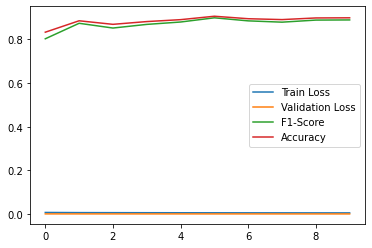

In [18]:
import matplotlib.pyplot as plt 

plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(F1_scores)
plt.plot(accuracies)
plt.legend(["Train Loss", "Validation Loss", "F1-Score", "Accuracy"])
plt.show()

#### Plot some wrong classified samples.


In [127]:
printloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(valid_x),torch.Tensor(valid_y)),batch_size=1)

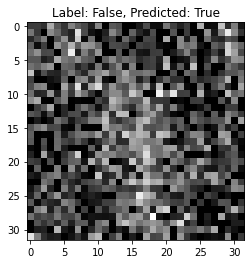

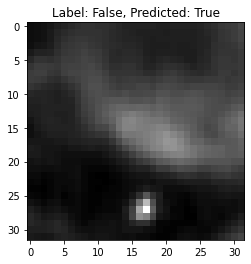

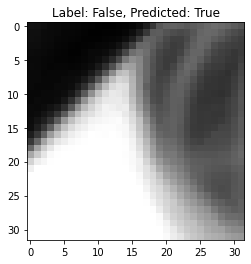

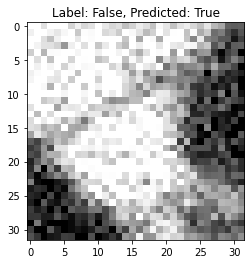

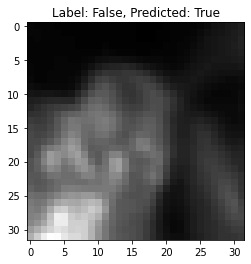

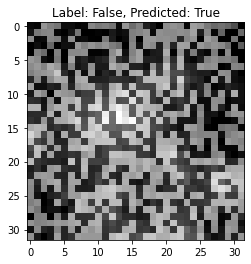

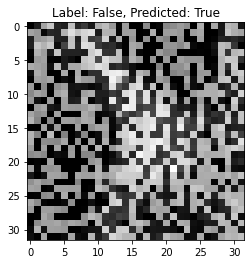

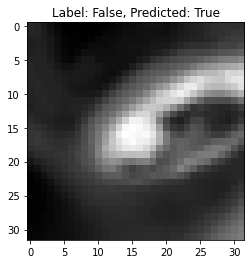

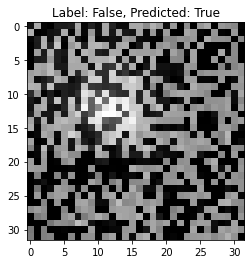

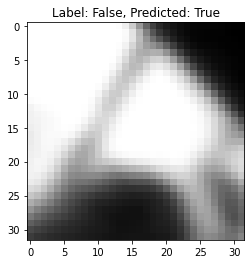

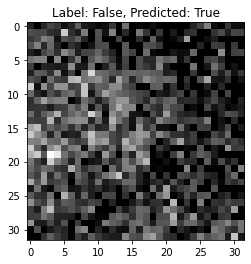

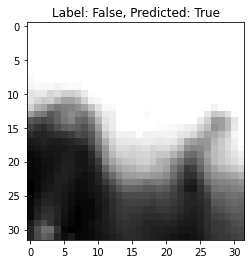

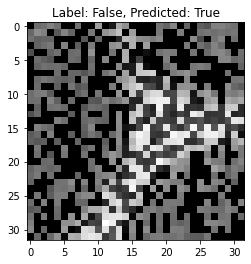

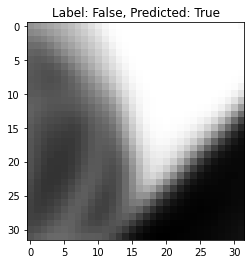

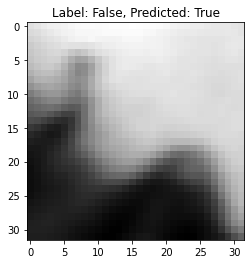

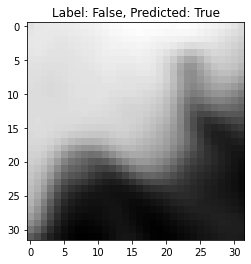

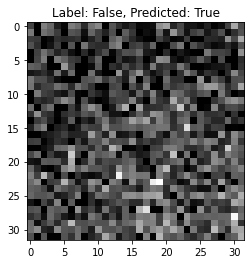

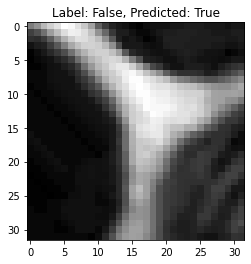

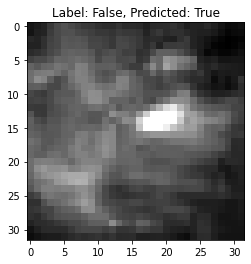

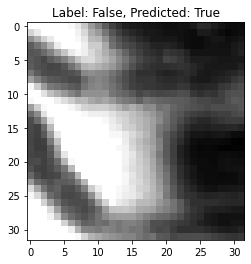

20

In [129]:
def print_false_positive(network, testloader):
    counter = 0
    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            predicted = (outputs >= 0.95) # Predicted is a tensor of booleans 
            predicted = predicted.view(predicted.size(0))
            labels = labels == 1
            if (predicted and not labels):
                title = 'Label: False, Predicted: True'
                fig, ax = plt.subplots()
                plt.imshow(np.array(inputs[0]), cmap='gray')
                ax.set_title(title)
                plt.show()
                counter += 1
                if counter == 20:
                    break
    return counter 
    
print_false_positive(network, printloader)

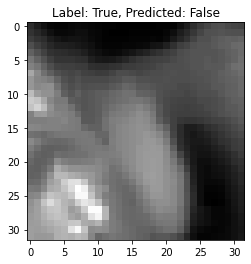

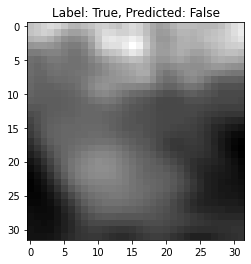

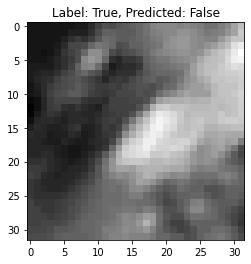

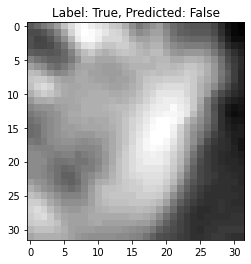

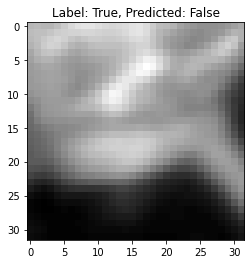

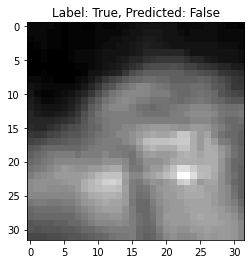

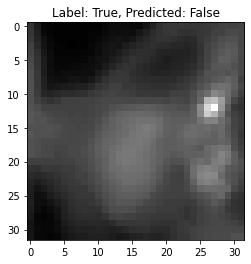

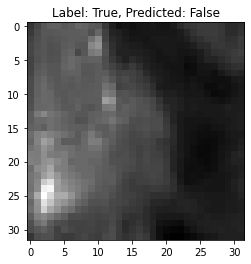

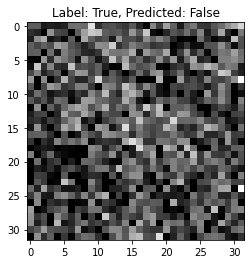

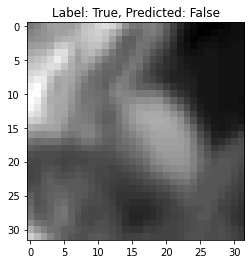

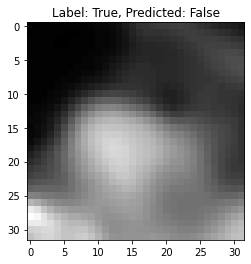

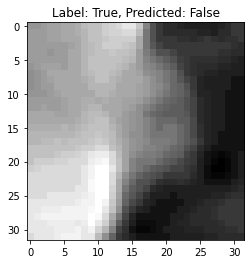

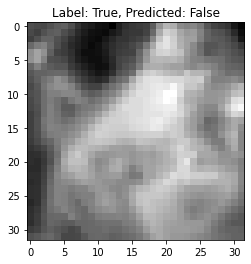

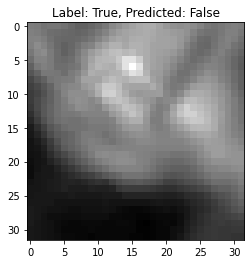

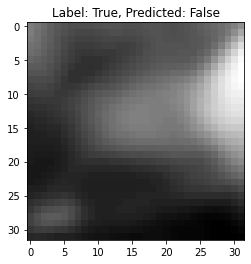

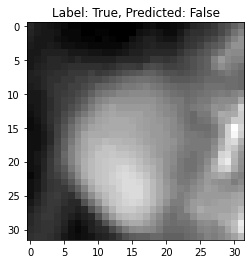

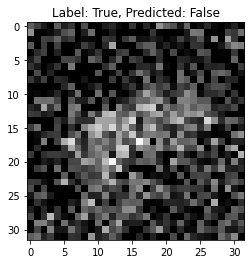

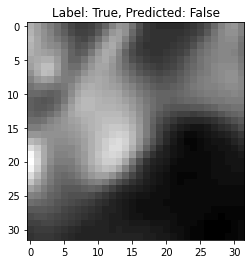

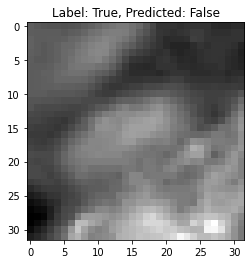

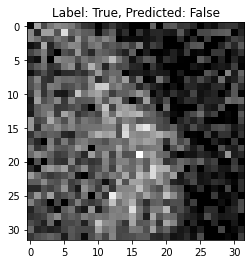

20

In [131]:
def print_false_negative(network, testloader):
    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    counter = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            predicted = (outputs >= 0.95) # Predicted is a tensor of booleans 
            predicted = predicted.view(predicted.size(0))
            labels = labels == 1
            if (not predicted and labels):
                title = 'Label: True, Predicted: False'
                fig, ax = plt.subplots()
                plt.imshow(np.array(inputs[0]), cmap='gray')
                ax.set_title(title)
                plt.show()
                counter += 1
                if counter == 20:
                    break
    return counter
    
print_false_negative(network, printloader)

# Create Heatmaps of full size images

We start with loading some full size images:

In [195]:
cur_dir = os.getcwd()
full_size_files = cur_dir + '/Fullsize/img/'
full_size_images = [] 

for file in os.listdir(full_size_files):
    if '.png' in file:
        try:
            path = os.path.join(full_size_files, file)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            full_size_images.append(np.array(img))
        except Exception as e:
            print(folder, file, str(e))

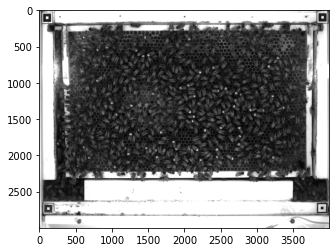

In [196]:
# show one of the full size images:

plt.imshow(full_size_images[0], cmap="gray")
plt.show()

In [197]:
fullsizeloader  = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(full_size_images),torch.Tensor(full_size_images)),batch_size=1)

In [198]:
def heat(network, testloader):
    heatmaps = []
    print('Creating heatmaps...')
    with torch.no_grad():

        for i, (inputs, labels) in enumerate(testloader):
            print('Begin of the loop:')
            outputs = network(torch.transpose(inputs[...,None],1,3))
            heatmaps.append(outputs)
            
    print('Heatmaps created.')
    return heatmaps

In [199]:
heatmaps = heat(network,fullsizeloader)

Trying to create heatmaps...
Begin of the loop:
tensor([[[[1.0786e-01, 2.9816e-01, 2.2337e-01,  ..., 7.4076e-19,
           1.8565e-25, 1.3394e-27],
          [1.0573e-06, 3.4079e-03, 2.4927e-02,  ..., 3.9894e-17,
           1.0439e-20, 1.0343e-24],
          [8.9508e-36, 4.6328e-13, 1.5071e-04,  ..., 1.7397e-19,
           3.8474e-18, 6.4276e-18],
          ...,
          [0.0000e+00, 3.2532e-32, 1.2517e-22,  ..., 1.0888e-20,
           2.3776e-21, 1.2802e-21],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.1002e-18,
           2.8347e-19, 3.3935e-19],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.1034e-18,
           3.6586e-18, 1.2006e-17]]]])
Begin of the loop:
tensor([[[[1.1193e-02, 2.2751e-02, 3.1256e-02,  ..., 6.7297e-12,
           1.1932e-21, 9.7289e-27],
          [1.8388e-05, 6.4773e-03, 1.2347e-02,  ..., 3.1179e-10,
           6.2267e-17, 1.4348e-24],
          [7.6815e-29, 1.6917e-06, 7.1603e-03,  ..., 2.6410e-13,
           3.0734e-12, 4.1962e-12],
      

tensor([[[[3.2464e-02, 1.1164e-01, 2.3427e-01,  ..., 1.0758e-23,
           3.1279e-32, 2.4303e-37],
          [2.6932e-05, 8.9791e-03, 3.6097e-02,  ..., 2.8387e-21,
           5.6511e-26, 2.1594e-31],
          [6.7463e-38, 3.4728e-09, 2.8335e-03,  ..., 1.8296e-24,
           7.1148e-23, 1.0284e-22],
          ...,
          [0.0000e+00, 3.3162e-26, 4.1137e-18,  ..., 3.3882e-27,
           2.0934e-27, 2.7990e-28],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4287e-23,
           7.4580e-24, 1.8168e-24],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5955e-21,
           2.0421e-21, 1.1665e-21]]]])
Begin of the loop:
tensor([[[[3.0407e-02, 1.5602e-01, 2.3926e-01,  ..., 2.6098e-26,
           7.0768e-39, 0.0000e+00],
          [3.4077e-06, 1.8694e-02, 3.3204e-02,  ..., 8.1527e-24,
           2.2203e-29, 5.8000e-37],
          [0.0000e+00, 2.6369e-10, 1.4900e-04,  ..., 1.4321e-28,
           8.0574e-27, 2.1850e-25],
          ...,
          [0.0000e+00, 0.0000e+00, 5.83

In [200]:
print(len(heatmaps))

20


In [201]:
print(heatmaps[0][0,0,:,:].shape)

torch.Size([993, 743])


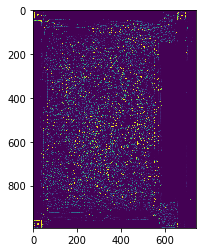

In [202]:
plt.imshow(np.array((heatmaps[0][0,0,:,:])), interpolation = 'none')
plt.show()

In [222]:
first_heatmap = heatmaps[0][0,0,:,:]
first_heatmap = np.array(torch.transpose(first_heatmap,0,1))

In [223]:
first_heatmap[first_heatmap > 0.98] = 1
first_heatmap[first_heatmap <= 0.98] = 0

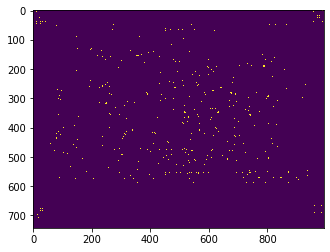

In [224]:
plt.imshow(first_heatmap, interpolation = 'none')
plt.show()

In [225]:
image = Image.fromarray(np.uint8(cm.gray(first_heatmap)*255))

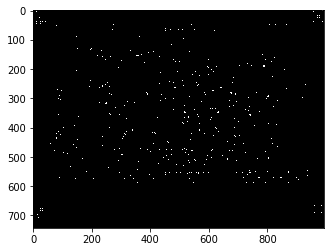

In [226]:
plt.imshow(image, interpolation = 'none')
plt.show()

In [227]:
image_rescaled = image.resize((4000,3000))

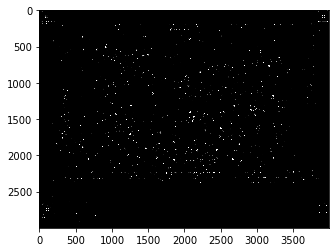

In [228]:
plt.imshow(image_rescaled, interpolation = 'none')
plt.show()